# Plain LSTM sequence to sequence model approach

* This approach uses a simple encoder/decoder LSTM approach 
* No stacked LSTMS
* No bidirectional

In [16]:
import torch
import torch.nn as nn
import numpy as np
from models.lstm_seq import LSTMPredictor
from data import OhioData
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm import tqdm


# Parameters

* I just tried out a few parameters
* One can optimize them by using hyper parameter search metrics (baysian parameter optimization)

In [44]:
# parameters

epochs = 250
n_batches = 1024
input_dim = 24
n_features = 11
n_layers = 1
output_dim = 6 # prediction horizon
amount_fc = 3
hidden_dim = 10
early_stopping_counter = 10

lr = 1e-4

# Loading data

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

val_data = OhioData(mode="validation", h=output_dim)

train_data = OhioData(h=output_dim)

# Utils
* Plots the prediction and the label of a single example

In [25]:
def plot_example(y, y_pred, inp, scale_factor=400):
    with torch.no_grad():
        idx_list = list(range(len(inp) + len(y)))
        y_pred *= scale_factor
        inp = np.append(inp, y) * scale_factor
        fig, ax = plt.subplots(1)
        ax.plot(idx_list, inp, label="Input + Label")
        ax.plot(idx_list[-output_dim:], y_pred, label="Predicted Label")
        ax.legend()
        ax.set_title("Predicted vs actual future")
    return fig

* the input is reshaped to: (sequence length, batch_size, features)
* data[0, 0, :] describes the data of a single time step

In [20]:
def prepare_data(batch):
    batch = batch.reshape(batch.shape[0], input_dim, n_features).permute(1, 0, 2)
    return batch

# Training Loop

In [21]:
train_loader = DataLoader(train_data, batch_size=n_batches, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=n_batches, shuffle=False, num_workers=0)

model = LSTMPredictor(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, prediction_horizon=output_dim, bidirectional=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.5, patience=3)
scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.99)

## Approach
1. Vizualize prediction of the current model
2. Run model on validation set
3. Train on train data
   
## Notes
* Early stopping is used 
* two separate lr schedulers are used

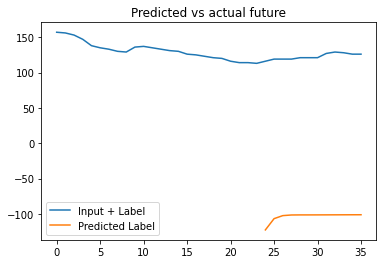

[Training:0] Total Loss: 410.42 Loss: 384.53: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([-0.2104, -0.1946, -0.1966, -0.2014, -0.2055, -0.2082, -0.2098, -0.2109,
        -0.2115, -0.2120, -0.2120, -0.2120], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([0.3275, 0.3275, 0.3275, 0.3275, 0.3250, 0.3250, 0.3250, 0.3225, 0.3200,
        0.3150, 0.3250, 0.3275], device='cuda:0')


[Training:1] Total Loss: 354.83 Loss: 321.65: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]


tensor([-0.1618, -0.1434, -0.1466, -0.1535, -0.1596, -0.1637, -0.1657, -0.1664,
        -0.1662, -0.1656, -0.1648, -0.1641], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([0.2200, 0.2400, 0.2550, 0.2600, 0.2550, 0.2650, 0.2900, 0.3100, 0.3325,
        0.3525, 0.3675, 0.3775], device='cuda:0')


[Training:2] Total Loss: 287.74 Loss: 261.85: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]


tensor([-0.1285, -0.0818, -0.0743, -0.0780, -0.0836, -0.0882, -0.0914, -0.0936,
        -0.0951, -0.0964, -0.0974, -0.0982], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([0.3825, 0.3825, 0.3825, 0.3825, 0.3800, 0.3800, 0.3800, 0.3800, 0.3750,
        0.3650, 0.3575, 0.3550], device='cuda:0')


[Training:3] Total Loss: 196.22 Loss: 136.01: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]


tensor([ 0.0296,  0.0710,  0.0698,  0.0577,  0.0439,  0.0314,  0.0209,  0.0125,
         0.0058,  0.0004, -0.0038, -0.0070], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([0.2700, 0.2500, 0.2450, 0.2400, 0.2300, 0.2200, 0.2125, 0.2050, 0.1975,
        0.1900, 0.1900, 0.1875], device='cuda:0')


[Training:4] Total Loss: 82.36 Loss: 34.42: 100%|██████████| 93/93 [00:19<00:00,  4.79it/s] 


tensor([0.2301, 0.2981, 0.3147, 0.3134, 0.3047, 0.2926, 0.2794, 0.2662, 0.2542,
        0.2436, 0.2344, 0.2264], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3400, 0.3325, 0.3275, 0.3225, 0.3200, 0.3275, 0.3175, 0.3175, 0.3225,
        0.3275, 0.3275, 0.3275], device='cuda:0')


[Training:5] Total Loss: 23.05 Loss: 19.56: 100%|██████████| 93/93 [00:19<00:00,  4.80it/s]


tensor([0.2219, 0.3085, 0.3344, 0.3404, 0.3390, 0.3346, 0.3292, 0.3238, 0.3188,
        0.3140, 0.3090, 0.3039], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3300, 0.3250, 0.3175, 0.3125, 0.2975, 0.2925, 0.2825, 0.2825, 0.2825,
        0.2650, 0.2450, 0.2250], device='cuda:0')


[Training:6] Total Loss: 18.49 Loss: 19.35: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


tensor([0.2099, 0.3099, 0.3425, 0.3534, 0.3560, 0.3546, 0.3516, 0.3476, 0.3431,
        0.3385, 0.3340, 0.3298], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4475, 0.4225, 0.4025, 0.3900, 0.3825, 0.3725, 0.3675, 0.3500, 0.3375,
        0.3275, 0.3200, 0.3125], device='cuda:0')


[Training:7] Total Loss: 17.68 Loss: 16.05: 100%|██████████| 93/93 [00:19<00:00,  4.68it/s]


tensor([0.2692, 0.3454, 0.3681, 0.3717, 0.3671, 0.3587, 0.3487, 0.3382, 0.3281,
        0.3188, 0.3107, 0.3039], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1750, 0.1725, 0.1700, 0.1650, 0.1575, 0.1550, 0.1525, 0.1500, 0.1525,
        0.1525, 0.1625, 0.1725], device='cuda:0')


[Training:8] Total Loss: 16.89 Loss: 17.73: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]


tensor([0.2451, 0.3254, 0.3512, 0.3568, 0.3541, 0.3473, 0.3385, 0.3291, 0.3201,
        0.3121, 0.3055, 0.3008], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2075, 0.1975, 0.1875, 0.1850, 0.1850, 0.1800, 0.1725, 0.1700, 0.1725,
        0.1775, 0.1950, 0.2250], device='cuda:0')


[Training:9] Total Loss: 16.07 Loss: 16.20: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]


tensor([0.2723, 0.3601, 0.3891, 0.3953, 0.3925, 0.3861, 0.3786, 0.3711, 0.3645,
        0.3582, 0.3524, 0.3476], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3100, 0.3175, 0.3200, 0.3125, 0.3175, 0.3250, 0.3300, 0.3400, 0.3500,
        0.3400, 0.3450, 0.3500], device='cuda:0')


[Training:10] Total Loss: 15.45 Loss: 15.52: 100%|██████████| 93/93 [00:19<00:00,  4.81it/s]


tensor([0.2843, 0.3594, 0.3799, 0.3827, 0.3787, 0.3715, 0.3626, 0.3527, 0.3428,
        0.3337, 0.3255, 0.3183], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3025, 0.3100, 0.3050, 0.2900, 0.2850, 0.2725, 0.2550, 0.2325, 0.2275,
        0.2225, 0.2250, 0.2250], device='cuda:0')


[Training:11] Total Loss: 15.02 Loss: 16.16: 100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


tensor([0.1750, 0.2378, 0.2579, 0.2649, 0.2685, 0.2714, 0.2739, 0.2764, 0.2792,
        0.2815, 0.2830, 0.2840], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3600, 0.3575, 0.3500, 0.3425, 0.3450, 0.3425, 0.3325, 0.3350, 0.3375,
        0.3225, 0.3100, 0.3000], device='cuda:0')


[Training:12] Total Loss: 14.57 Loss: 13.68: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]


tensor([0.3060, 0.3695, 0.3862, 0.3882, 0.3852, 0.3795, 0.3723, 0.3644, 0.3561,
        0.3479, 0.3398, 0.3322], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.2050, 0.2225, 0.2400, 0.2575, 0.2650, 0.2700, 0.2725, 0.2700,
        0.2650, 0.2575, 0.2525], device='cuda:0')


[Training:13] Total Loss: 14.12 Loss: 14.68: 100%|██████████| 93/93 [00:20<00:00,  4.57it/s]


tensor([0.4363, 0.5044, 0.5299, 0.5398, 0.5424, 0.5404, 0.5347, 0.5240, 0.5085,
        0.4927, 0.4775, 0.4637], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.8675, 0.8525, 0.8300, 0.8025, 0.7750, 0.7400, 0.6975, 0.5100, 0.4875,
        0.4525, 0.4500, 0.4550], device='cuda:0')


[Training:14] Total Loss: 13.76 Loss: 12.97: 100%|██████████| 93/93 [00:20<00:00,  4.58it/s]


tensor([0.3091, 0.3900, 0.4143, 0.4211, 0.4217, 0.4203, 0.4187, 0.4175, 0.4166,
        0.4156, 0.4142, 0.4128], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5350, 0.5225, 0.5100, 0.5000, 0.5075, 0.5300, 0.5550, 0.5775, 0.5925,
        0.5875, 0.5775, 0.5850], device='cuda:0')


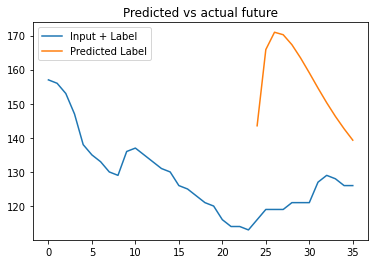

[Training:15] Total Loss: 13.52 Loss: 12.91: 100%|██████████| 93/93 [00:20<00:00,  4.62it/s]


tensor([0.2939, 0.3533, 0.3636, 0.3594, 0.3504, 0.3396, 0.3288, 0.3184, 0.3090,
        0.3021, 0.2975, 0.2945], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1775, 0.1750, 0.1750, 0.1825, 0.1825, 0.1825, 0.1875, 0.1850, 0.1875,
        0.2200, 0.2425, 0.2600], device='cuda:0')


[Training:16] Total Loss: 13.28 Loss: 13.65: 100%|██████████| 93/93 [00:19<00:00,  4.73it/s]


tensor([0.3662, 0.4348, 0.4610, 0.4718, 0.4753, 0.4745, 0.4718, 0.4682, 0.4643,
        0.4602, 0.4561, 0.4517], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5075, 0.5625, 0.6000, 0.6225, 0.6125, 0.6175, 0.6225, 0.6300, 0.6325,
        0.6300, 0.6200, 0.6075], device='cuda:0')


[Training:17] Total Loss: 13.02 Loss: 12.83: 100%|██████████| 93/93 [00:19<00:00,  4.80it/s]


tensor([0.2905, 0.3542, 0.3670, 0.3639, 0.3548, 0.3432, 0.3309, 0.3187, 0.3068,
        0.2957, 0.2856, 0.2762], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2525, 0.2425, 0.2300, 0.2150, 0.1975, 0.1850, 0.1775, 0.1650, 0.1550,
        0.1475, 0.1450, 0.1350], device='cuda:0')


[Training:18] Total Loss: 12.82 Loss: 13.76: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]


tensor([0.3569, 0.4178, 0.4341, 0.4355, 0.4312, 0.4238, 0.4145, 0.4042, 0.3938,
        0.3836, 0.3740, 0.3657], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3700, 0.3650, 0.3525, 0.3450, 0.3425, 0.3325, 0.3250, 0.3200, 0.3200,
        0.3100, 0.3125, 0.3200], device='cuda:0')


[Training:19] Total Loss: 12.68 Loss: 12.19: 100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


tensor([0.3343, 0.3868, 0.3962, 0.3920, 0.3835, 0.3735, 0.3630, 0.3526, 0.3428,
        0.3342, 0.3274, 0.3218], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1975, 0.1950, 0.1975, 0.1975, 0.2025, 0.2125, 0.2200, 0.2275, 0.2350,
        0.2475, 0.2675, 0.2750], device='cuda:0')


[Training:20] Total Loss: 12.54 Loss: 11.98: 100%|██████████| 93/93 [00:19<00:00,  4.69it/s]


tensor([0.3396, 0.4018, 0.4199, 0.4223, 0.4181, 0.4101, 0.3997, 0.3885, 0.3781,
        0.3689, 0.3609, 0.3541], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3475, 0.3600, 0.3600, 0.3525, 0.3325, 0.3125, 0.3025, 0.3075,
        0.3150, 0.3175, 0.3250], device='cuda:0')


[Training:21] Total Loss: 12.40 Loss: 11.73: 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


tensor([0.3259, 0.3777, 0.3813, 0.3711, 0.3565, 0.3406, 0.3254, 0.3116, 0.2992,
        0.2883, 0.2793, 0.2712], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1700, 0.1650, 0.1625, 0.1575, 0.1500, 0.1425, 0.1450, 0.1475, 0.1475,
        0.1500, 0.1575, 0.1525], device='cuda:0')


[Training:22] Total Loss: 12.29 Loss: 11.33: 100%|██████████| 93/93 [00:20<00:00,  4.60it/s]


tensor([0.3445, 0.4115, 0.4292, 0.4314, 0.4277, 0.4212, 0.4137, 0.4059, 0.3982,
        0.3907, 0.3838, 0.3776], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4275, 0.4225, 0.4200, 0.4150, 0.4050, 0.4000, 0.3975, 0.3925, 0.3850,
        0.3800, 0.3775, 0.3775], device='cuda:0')


[Training:23] Total Loss: 12.22 Loss: 12.04: 100%|██████████| 93/93 [00:18<00:00,  5.09it/s]


tensor([0.3253, 0.3953, 0.4149, 0.4186, 0.4169, 0.4132, 0.4085, 0.4034, 0.3981,
        0.3930, 0.3887, 0.3851], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4500, 0.4525, 0.4525, 0.4550, 0.4575, 0.4600, 0.4525, 0.4425, 0.4325,
        0.4300, 0.4325, 0.4375], device='cuda:0')


[Training:24] Total Loss: 12.15 Loss: 12.70: 100%|██████████| 93/93 [00:18<00:00,  5.16it/s]


tensor([0.3241, 0.3946, 0.4145, 0.4182, 0.4159, 0.4113, 0.4059, 0.4004, 0.3955,
        0.3916, 0.3886, 0.3867], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4225, 0.4225, 0.4275, 0.4275, 0.4250, 0.4275, 0.4300, 0.4250, 0.4350,
        0.4450, 0.4550, 0.4675], device='cuda:0')


[Training:25] Total Loss: 12.07 Loss: 11.68: 100%|██████████| 93/93 [00:18<00:00,  5.04it/s]


tensor([0.3862, 0.4543, 0.4735, 0.4783, 0.4782, 0.4762, 0.4734, 0.4705, 0.4677,
        0.4649, 0.4619, 0.4587], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5275, 0.5475, 0.5675, 0.5875, 0.6025, 0.6150, 0.6225, 0.6300, 0.6325,
        0.6300, 0.6200, 0.6075], device='cuda:0')


[Training:26] Total Loss: 12.00 Loss: 13.37: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.2776, 0.3455, 0.3663, 0.3698, 0.3666, 0.3606, 0.3534, 0.3459, 0.3387,
        0.3322, 0.3263, 0.3207], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2700, 0.2775, 0.2850, 0.2925, 0.2975, 0.3025, 0.2975, 0.2925, 0.2925,
        0.2900, 0.2875, 0.2800], device='cuda:0')


[Training:27] Total Loss: 11.91 Loss: 12.20: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.3677, 0.4456, 0.4771, 0.4899, 0.4946, 0.4947, 0.4924, 0.4890, 0.4854,
        0.4822, 0.4795, 0.4771], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6500, 0.6525, 0.6525, 0.6525, 0.6525, 0.6450, 0.6450, 0.6450, 0.6500,
        0.6650, 0.6675, 0.6750], device='cuda:0')


[Training:28] Total Loss: 11.83 Loss: 11.95: 100%|██████████| 93/93 [00:17<00:00,  5.18it/s]


tensor([0.3534, 0.4133, 0.4248, 0.4222, 0.4156, 0.4076, 0.3991, 0.3902, 0.3821,
        0.3754, 0.3699, 0.3655], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3425, 0.3400, 0.3375, 0.3375, 0.3500, 0.3575, 0.3525, 0.3450, 0.3500,
        0.3650, 0.3725, 0.3800], device='cuda:0')


[Training:29] Total Loss: 11.74 Loss: 10.81: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.3319, 0.4062, 0.4329, 0.4408, 0.4405, 0.4361, 0.4301, 0.4234, 0.4167,
        0.4099, 0.4031, 0.3963], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4975, 0.4900, 0.4725, 0.4550, 0.4425, 0.4350, 0.4375, 0.4325, 0.4350,
        0.4200, 0.4100, 0.4000], device='cuda:0')


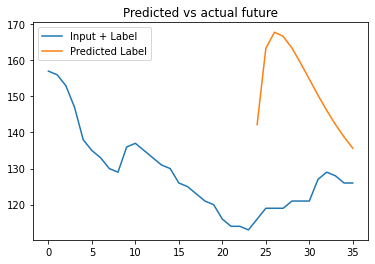

[Training:30] Total Loss: 11.66 Loss: 11.22: 100%|██████████| 93/93 [00:20<00:00,  4.49it/s]


tensor([0.2935, 0.3565, 0.3740, 0.3753, 0.3721, 0.3689, 0.3660, 0.3636, 0.3630,
        0.3655, 0.3706, 0.3763], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2625, 0.2550, 0.2650, 0.2700, 0.3100, 0.3600, 0.3775, 0.3975, 0.4375,
        0.4975, 0.5500, 0.5625], device='cuda:0')


[Training:31] Total Loss: 11.58 Loss: 11.77: 100%|██████████| 93/93 [00:22<00:00,  4.19it/s]


tensor([0.3181, 0.3823, 0.3966, 0.3954, 0.3885, 0.3795, 0.3703, 0.3610, 0.3520,
        0.3438, 0.3363, 0.3298], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3400, 0.3275, 0.3200, 0.3100, 0.3075, 0.3050, 0.2975, 0.2875,
        0.2875, 0.2825, 0.2850], device='cuda:0')


[Training:32] Total Loss: 11.49 Loss: 10.46: 100%|██████████| 93/93 [00:22<00:00,  4.08it/s]


tensor([0.3346, 0.3950, 0.4074, 0.4052, 0.3983, 0.3902, 0.3815, 0.3722, 0.3642,
        0.3582, 0.3536, 0.3498], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3300, 0.3300, 0.3300, 0.3275, 0.3325, 0.3400, 0.3300, 0.3125, 0.3300,
        0.3475, 0.3550, 0.3575], device='cuda:0')


[Training:33] Total Loss: 11.41 Loss: 12.05: 100%|██████████| 93/93 [00:20<00:00,  4.65it/s]


tensor([0.3578, 0.4202, 0.4395, 0.4443, 0.4441, 0.4414, 0.4365, 0.4303, 0.4242,
        0.4183, 0.4126, 0.4075], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4150, 0.4125, 0.4125, 0.4225, 0.4350, 0.4450, 0.4300, 0.4325, 0.4400,
        0.4400, 0.4400, 0.4425], device='cuda:0')


[Training:34] Total Loss: 11.32 Loss: 10.81: 100%|██████████| 93/93 [00:20<00:00,  4.63it/s]


tensor([0.2190, 0.2887, 0.3097, 0.3124, 0.3078, 0.3002, 0.2918, 0.2836, 0.2761,
        0.2694, 0.2639, 0.2598], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1775, 0.1900, 0.2000, 0.2050, 0.2050, 0.2025, 0.2000, 0.1975, 0.1925,
        0.1925, 0.1950, 0.2050], device='cuda:0')


[Training:35] Total Loss: 11.22 Loss: 9.96: 100%|██████████| 93/93 [00:19<00:00,  4.67it/s] 


tensor([0.2805, 0.3617, 0.3885, 0.3984, 0.4027, 0.4048, 0.4055, 0.4053, 0.4045,
        0.4031, 0.4015, 0.3995], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5625, 0.5550, 0.5475, 0.5375, 0.5425, 0.5400, 0.5275, 0.5175, 0.5050,
        0.4925, 0.4850, 0.4725], device='cuda:0')


[Training:36] Total Loss: 11.14 Loss: 11.54: 100%|██████████| 93/93 [00:20<00:00,  4.64it/s]


tensor([0.2595, 0.3348, 0.3616, 0.3696, 0.3697, 0.3662, 0.3612, 0.3566, 0.3534,
        0.3513, 0.3502, 0.3498], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3200, 0.3275, 0.3400, 0.3425, 0.3475, 0.3475, 0.3450, 0.3600, 0.3775,
        0.3900, 0.4025, 0.4075], device='cuda:0')


[Training:37] Total Loss: 11.05 Loss: 11.22: 100%|██████████| 93/93 [00:19<00:00,  4.65it/s]


tensor([0.3768, 0.4376, 0.4548, 0.4569, 0.4530, 0.4463, 0.4383, 0.4298, 0.4211,
        0.4129, 0.4053, 0.3984], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4050, 0.4050, 0.4025, 0.4025, 0.4025, 0.4025, 0.4025, 0.4025, 0.3975,
        0.3975, 0.3975, 0.3975], device='cuda:0')


[Training:38] Total Loss: 10.96 Loss: 11.39: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.3141, 0.3776, 0.3923, 0.3915, 0.3855, 0.3779, 0.3706, 0.3640, 0.3581,
        0.3535, 0.3500, 0.3470], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3525, 0.3550, 0.3500, 0.3425, 0.3375, 0.3350, 0.3450, 0.3450, 0.3475,
        0.3575, 0.3625, 0.3625], device='cuda:0')


[Training:39] Total Loss: 10.87 Loss: 10.97: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.3197, 0.3807, 0.3965, 0.3969, 0.3911, 0.3823, 0.3718, 0.3606, 0.3495,
        0.3394, 0.3305, 0.3231], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2975, 0.2900, 0.2850, 0.2825, 0.2775, 0.2700, 0.2625, 0.2550, 0.2525,
        0.2550, 0.2600, 0.2675], device='cuda:0')


[Training:40] Total Loss: 10.77 Loss: 9.85: 100%|██████████| 93/93 [00:19<00:00,  4.79it/s] 


tensor([0.3468, 0.4057, 0.4215, 0.4217, 0.4157, 0.4072, 0.3983, 0.3889, 0.3787,
        0.3690, 0.3600, 0.3514], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3550, 0.3500, 0.3400, 0.3350, 0.3350, 0.3350, 0.3450, 0.3325, 0.3125,
        0.3100, 0.3050, 0.2950], device='cuda:0')


[Training:41] Total Loss: 10.68 Loss: 10.15: 100%|██████████| 93/93 [00:19<00:00,  4.68it/s]


tensor([0.3038, 0.3785, 0.4062, 0.4161, 0.4185, 0.4173, 0.4144, 0.4112, 0.4081,
        0.4053, 0.4029, 0.4009], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4225, 0.4250, 0.4300, 0.4325, 0.4375, 0.4400, 0.4475, 0.4550, 0.4600,
        0.4650, 0.4650, 0.4700], device='cuda:0')


[Training:42] Total Loss: 10.58 Loss: 9.74: 100%|██████████| 93/93 [00:21<00:00,  4.38it/s] 


tensor([0.3495, 0.4062, 0.4148, 0.4086, 0.3968, 0.3834, 0.3699, 0.3568, 0.3443,
        0.3325, 0.3218, 0.3118], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3125, 0.2950, 0.2825, 0.2625, 0.2600, 0.2550, 0.2475, 0.2375,
        0.2300, 0.2250, 0.2175], device='cuda:0')


[Training:43] Total Loss: 10.49 Loss: 10.02: 100%|██████████| 93/93 [00:19<00:00,  4.78it/s]


tensor([0.3937, 0.4706, 0.5028, 0.5177, 0.5250, 0.5282, 0.5287, 0.5276, 0.5254,
        0.5220, 0.5177, 0.5137], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7200, 0.7050, 0.6975, 0.6900, 0.6875, 0.6925, 0.6850, 0.6925, 0.6850,
        0.6625, 0.6500, 0.6600], device='cuda:0')


[Training:44] Total Loss: 10.39 Loss: 9.38: 100%|██████████| 93/93 [00:19<00:00,  4.72it/s] 


tensor([0.3709, 0.4232, 0.4312, 0.4268, 0.4184, 0.4087, 0.3991, 0.3898, 0.3818,
        0.3752, 0.3698, 0.3651], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3300, 0.3300, 0.3325, 0.3350, 0.3350, 0.3400, 0.3425, 0.3425, 0.3525,
        0.3625, 0.3675, 0.3675], device='cuda:0')


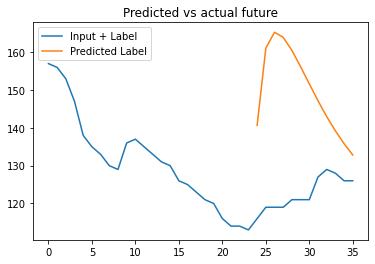

[Training:45] Total Loss: 10.30 Loss: 9.62: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s] 


tensor([0.3554, 0.4260, 0.4473, 0.4518, 0.4498, 0.4447, 0.4385, 0.4330, 0.4284,
        0.4245, 0.4215, 0.4188], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5150, 0.5125, 0.4950, 0.4775, 0.4675, 0.4575, 0.4525, 0.4675, 0.4750,
        0.4800, 0.4875, 0.4850], device='cuda:0')


[Training:46] Total Loss: 10.21 Loss: 9.84: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s] 


tensor([0.3682, 0.4196, 0.4215, 0.4081, 0.3902, 0.3717, 0.3542, 0.3386, 0.3251,
        0.3137, 0.3044, 0.2963], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3400, 0.2800, 0.2350, 0.2050, 0.1950, 0.1925, 0.1950, 0.2000, 0.2075,
        0.2150, 0.2225, 0.2225], device='cuda:0')


[Training:47] Total Loss: 10.11 Loss: 9.93: 100%|██████████| 93/93 [00:18<00:00,  5.04it/s] 


tensor([0.3771, 0.4351, 0.4518, 0.4546, 0.4523, 0.4473, 0.4401, 0.4317, 0.4238,
        0.4165, 0.4092, 0.4020], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4125, 0.4200, 0.4100, 0.4200, 0.4300, 0.4300, 0.4125, 0.4025, 0.4125,
        0.4100, 0.4000, 0.3900], device='cuda:0')


[Training:48] Total Loss: 10.02 Loss: 10.56: 100%|██████████| 93/93 [00:18<00:00,  5.15it/s]


tensor([0.3195, 0.3710, 0.3812, 0.3772, 0.3678, 0.3566, 0.3453, 0.3347, 0.3252,
        0.3168, 0.3093, 0.3026], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2475, 0.2475, 0.2450, 0.2450, 0.2450, 0.2475, 0.2500, 0.2525, 0.2550,
        0.2550, 0.2525, 0.2500], device='cuda:0')


[Training:49] Total Loss: 9.92 Loss: 8.37: 100%|██████████| 93/93 [00:18<00:00,  5.15it/s] 


tensor([0.1589, 0.2439, 0.2769, 0.2896, 0.2939, 0.2945, 0.2938, 0.2939, 0.2950,
        0.2960, 0.2963, 0.2965], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4100, 0.4050, 0.4050, 0.4025, 0.3750, 0.3475, 0.3325, 0.3375, 0.3450,
        0.3375, 0.3250, 0.3200], device='cuda:0')


[Training:50] Total Loss: 9.83 Loss: 9.10: 100%|██████████| 93/93 [00:18<00:00,  5.07it/s] 


tensor([0.3663, 0.4160, 0.4207, 0.4128, 0.4003, 0.3863, 0.3719, 0.3572, 0.3424,
        0.3284, 0.3151, 0.3023], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2975, 0.2900, 0.2925, 0.2825, 0.2700, 0.2600, 0.2500, 0.2325, 0.2125,
        0.2050, 0.1925, 0.1800], device='cuda:0')


[Training:51] Total Loss: 9.74 Loss: 10.03: 100%|██████████| 93/93 [00:18<00:00,  5.10it/s]


tensor([0.3700, 0.4221, 0.4275, 0.4183, 0.4042, 0.3881, 0.3715, 0.3560, 0.3409,
        0.3270, 0.3142, 0.3023], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3275, 0.3100, 0.2925, 0.2725, 0.2575, 0.2425, 0.2300, 0.2275, 0.2125,
        0.2075, 0.2000, 0.1925], device='cuda:0')


[Training:52] Total Loss: 9.64 Loss: 10.00: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.4852, 0.5410, 0.5619, 0.5705, 0.5733, 0.5729, 0.5700, 0.5651, 0.5592,
        0.5524, 0.5451, 0.5376], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7300, 0.7250, 0.7175, 0.7025, 0.6875, 0.6800, 0.6625, 0.6475, 0.6400,
        0.6250, 0.6100, 0.5975], device='cuda:0')


[Training:53] Total Loss: 9.54 Loss: 8.82: 100%|██████████| 93/93 [00:18<00:00,  5.15it/s] 


tensor([0.3316, 0.3934, 0.4121, 0.4158, 0.4137, 0.4091, 0.4036, 0.3980, 0.3930,
        0.3890, 0.3858, 0.3832], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3575, 0.3600, 0.3600, 0.3625, 0.3675, 0.3750, 0.3825, 0.3900, 0.4000,
        0.4100, 0.4175, 0.4200], device='cuda:0')


[Training:54] Total Loss: 9.45 Loss: 9.80: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s] 


tensor([0.3122, 0.3735, 0.3895, 0.3917, 0.3890, 0.3844, 0.3793, 0.3744, 0.3703,
        0.3671, 0.3646, 0.3629], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3525, 0.3575, 0.3600, 0.3650, 0.3700, 0.3725, 0.3750, 0.3775, 0.3850,
        0.3900, 0.3950, 0.4000], device='cuda:0')


[Training:55] Total Loss: 9.36 Loss: 9.60: 100%|██████████| 93/93 [00:17<00:00,  5.20it/s] 


tensor([0.3425, 0.3884, 0.3936, 0.3867, 0.3766, 0.3647, 0.3517, 0.3455, 0.3405,
        0.3350, 0.3294, 0.3237], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2250, 0.2150, 0.2100, 0.2225, 0.2400, 0.2325, 0.2275, 0.3325, 0.3225,
        0.3125, 0.3050, 0.2950], device='cuda:0')


[Training:56] Total Loss: 9.26 Loss: 9.02: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s] 


tensor([0.2933, 0.3597, 0.3808, 0.3851, 0.3821, 0.3758, 0.3684, 0.3612, 0.3543,
        0.3480, 0.3423, 0.3373], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3325, 0.3425, 0.3500, 0.3525, 0.3450, 0.3375, 0.3350, 0.3350, 0.3300,
        0.3275, 0.3250, 0.3225], device='cuda:0')


[Training:57] Total Loss: 9.17 Loss: 9.00: 100%|██████████| 93/93 [00:18<00:00,  5.16it/s] 


tensor([0.3712, 0.4323, 0.4520, 0.4566, 0.4560, 0.4535, 0.4501, 0.4465, 0.4431,
        0.4401, 0.4378, 0.4360], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4300, 0.4400, 0.4375, 0.4275, 0.4400, 0.4575, 0.4650, 0.4750, 0.4850,
        0.4925, 0.5000, 0.5050], device='cuda:0')


[Training:58] Total Loss: 9.08 Loss: 8.78: 100%|██████████| 93/93 [00:18<00:00,  5.02it/s] 


tensor([0.3057, 0.3670, 0.3816, 0.3814, 0.3759, 0.3685, 0.3604, 0.3516, 0.3421,
        0.3323, 0.3231, 0.3150], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3625, 0.3600, 0.3550, 0.3475, 0.3400, 0.3325, 0.3225, 0.3025, 0.2800,
        0.2625, 0.2575, 0.2575], device='cuda:0')


[Training:59] Total Loss: 8.98 Loss: 8.86: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.4895, 0.5541, 0.5833, 0.5994, 0.6094, 0.6155, 0.6183, 0.6183, 0.6162,
        0.6128, 0.6088, 0.6044], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.8750, 0.8750, 0.8700, 0.8750, 0.8775, 0.8725, 0.8525, 0.8250, 0.8025,
        0.7875, 0.7750, 0.7625], device='cuda:0')


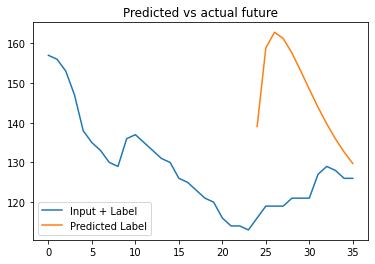

[Training:60] Total Loss: 8.90 Loss: 9.20: 100%|██████████| 93/93 [00:19<00:00,  4.78it/s]


tensor([0.3560, 0.4046, 0.4140, 0.4088, 0.3985, 0.3870, 0.3747, 0.3631, 0.3529,
        0.3450, 0.3380, 0.3329], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2875, 0.2875, 0.2900, 0.2675, 0.2700, 0.2825, 0.2725, 0.2825, 0.2900,
        0.3100, 0.3050, 0.3225], device='cuda:0')


[Training:61] Total Loss: 8.80 Loss: 8.06: 100%|██████████| 93/93 [00:19<00:00,  4.81it/s]


tensor([0.3281, 0.3988, 0.4255, 0.4343, 0.4356, 0.4340, 0.4317, 0.4298, 0.4293,
        0.4302, 0.4323, 0.4349], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4225, 0.4475, 0.4550, 0.4325, 0.4300, 0.4425, 0.4600, 0.4775, 0.5075,
        0.5300, 0.5475, 0.5575], device='cuda:0')


[Training:62] Total Loss: 8.71 Loss: 9.23: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.3546, 0.4106, 0.4237, 0.4238, 0.4193, 0.4129, 0.4052, 0.3971, 0.3898,
        0.3848, 0.3819, 0.3801], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3650, 0.3875, 0.4025, 0.3975, 0.3975, 0.3925, 0.3775, 0.3675, 0.3725,
        0.3950, 0.4150, 0.4200], device='cuda:0')


[Training:63] Total Loss: 8.62 Loss: 7.52: 100%|██████████| 93/93 [00:19<00:00,  4.80it/s]


tensor([0.3077, 0.3546, 0.3550, 0.3437, 0.3299, 0.3169, 0.3068, 0.3008, 0.2983,
        0.2985, 0.2995, 0.3009], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2075, 0.1850, 0.1725, 0.1825, 0.1925, 0.2100, 0.2400, 0.2825, 0.3150,
        0.3425, 0.3450, 0.3500], device='cuda:0')


[Training:64] Total Loss: 8.53 Loss: 8.75: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.3751, 0.4339, 0.4489, 0.4506, 0.4475, 0.4425, 0.4366, 0.4311, 0.4262,
        0.4219, 0.4181, 0.4146], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4425, 0.4425, 0.4400, 0.4375, 0.4375, 0.4375, 0.4350, 0.4400, 0.4450,
        0.4450, 0.4450, 0.4425], device='cuda:0')


[Training:65] Total Loss: 8.45 Loss: 8.59: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.3713, 0.4417, 0.4691, 0.4800, 0.4837, 0.4834, 0.4810, 0.4769, 0.4720,
        0.4668, 0.4615, 0.4564], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5350, 0.5350, 0.5300, 0.5225, 0.5175, 0.5125, 0.5125, 0.4975, 0.4950,
        0.4875, 0.4825, 0.4775], device='cuda:0')


[Training:66] Total Loss: 8.36 Loss: 8.63: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.3779, 0.4242, 0.4329, 0.4279, 0.4174, 0.4034, 0.3873, 0.3707, 0.3547,
        0.3407, 0.3296, 0.3206], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3325, 0.3250, 0.3200, 0.2975, 0.2825, 0.2600, 0.2400, 0.2325, 0.2275,
        0.2400, 0.2575, 0.2675], device='cuda:0')


[Training:67] Total Loss: 8.27 Loss: 8.07: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.3175, 0.3637, 0.3666, 0.3575, 0.3447, 0.3311, 0.3177, 0.3042, 0.2914,
        0.2803, 0.2704, 0.2616], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2400, 0.2400, 0.2325, 0.2275, 0.2250, 0.2225, 0.2175, 0.2025, 0.1950,
        0.1975, 0.1950, 0.1925], device='cuda:0')


[Training:68] Total Loss: 8.18 Loss: 7.84: 100%|██████████| 93/93 [00:18<00:00,  5.09it/s]


tensor([0.4005, 0.4454, 0.4532, 0.4493, 0.4412, 0.4313, 0.4202, 0.4095, 0.3996,
        0.3899, 0.3797, 0.3699], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3650, 0.3575, 0.3400, 0.3425, 0.3425, 0.3425, 0.3350, 0.3450, 0.3475,
        0.3375, 0.3200, 0.3150], device='cuda:0')


[Training:69] Total Loss: 8.10 Loss: 7.61: 100%|██████████| 93/93 [00:19<00:00,  4.85it/s]


tensor([0.3672, 0.4095, 0.4106, 0.3997, 0.3854, 0.3710, 0.3557, 0.3406, 0.3282,
        0.3198, 0.3144, 0.3120], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2475, 0.2600, 0.2700, 0.2550, 0.2525, 0.2600, 0.2375, 0.2300, 0.2475,
        0.2825, 0.3025, 0.3300], device='cuda:0')


[Training:70] Total Loss: 8.01 Loss: 7.08: 100%|██████████| 93/93 [00:19<00:00,  4.66it/s]


tensor([0.3346, 0.3905, 0.4030, 0.4027, 0.3975, 0.3901, 0.3821, 0.3746, 0.3676,
        0.3612, 0.3556, 0.3506], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3525, 0.3550, 0.3625, 0.3675, 0.3625, 0.3525, 0.3500, 0.3500, 0.3475,
        0.3450, 0.3425, 0.3425], device='cuda:0')


[Training:71] Total Loss: 7.93 Loss: 7.39: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.2368, 0.2811, 0.2828, 0.2723, 0.2590, 0.2463, 0.2353, 0.2267, 0.2200,
        0.2153, 0.2122, 0.2105], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1450, 0.1450, 0.1425, 0.1425, 0.1475, 0.1550, 0.1625, 0.1725, 0.1800,
        0.1875, 0.1975, 0.2050], device='cuda:0')


[Training:72] Total Loss: 7.85 Loss: 7.93: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.3173, 0.3710, 0.3837, 0.3827, 0.3767, 0.3689, 0.3609, 0.3535, 0.3466,
        0.3405, 0.3356, 0.3321], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2700, 0.2725, 0.2825, 0.2900, 0.2975, 0.3050, 0.3150, 0.3225, 0.3225,
        0.3250, 0.3325, 0.3400], device='cuda:0')


[Training:73] Total Loss: 7.77 Loss: 7.43: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.3807, 0.4449, 0.4662, 0.4705, 0.4669, 0.4591, 0.4494, 0.4391, 0.4303,
        0.4234, 0.4180, 0.4138], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4875, 0.4675, 0.4500, 0.4275, 0.4075, 0.3925, 0.3850, 0.3825, 0.4000,
        0.4150, 0.4250, 0.4300], device='cuda:0')


[Training:74] Total Loss: 7.69 Loss: 7.39: 100%|██████████| 93/93 [00:19<00:00,  4.80it/s]

tensor([0.4052, 0.4617, 0.4755, 0.4765, 0.4731, 0.4683, 0.4638, 0.4605, 0.4579,
        0.4558, 0.4542, 0.4532], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4725, 0.4750, 0.4700, 0.4650, 0.4675, 0.4725, 0.4825, 0.5000, 0.5025,
        0.5050, 0.5075, 0.5125], device='cuda:0')


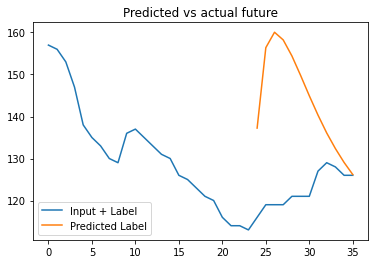

[Training:75] Total Loss: 7.61 Loss: 7.25: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


tensor([0.2719, 0.3283, 0.3387, 0.3319, 0.3186, 0.3031, 0.2868, 0.2723, 0.2632,
        0.2592, 0.2602, 0.2649], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2150, 0.1950, 0.1875, 0.1775, 0.1725, 0.1700, 0.1600, 0.1725, 0.2200,
        0.2650, 0.3150, 0.3550], device='cuda:0')


[Training:76] Total Loss: 7.53 Loss: 7.49: 100%|██████████| 93/93 [00:19<00:00,  4.83it/s]


tensor([0.3852, 0.4433, 0.4592, 0.4622, 0.4603, 0.4569, 0.4531, 0.4494, 0.4455,
        0.4417, 0.4380, 0.4347], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4600, 0.4675, 0.4675, 0.4625, 0.4600, 0.4675, 0.4725, 0.4725, 0.4675,
        0.4625, 0.4600, 0.4575], device='cuda:0')


[Training:77] Total Loss: 7.46 Loss: 7.54: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.2624, 0.3133, 0.3215, 0.3173, 0.3084, 0.2971, 0.2856, 0.2754, 0.2665,
        0.2590, 0.2531, 0.2484], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2475, 0.2500, 0.2575, 0.2575, 0.2450, 0.2250, 0.2175, 0.2175, 0.2175,
        0.2200, 0.2250, 0.2275], device='cuda:0')


[Training:78] Total Loss: 7.38 Loss: 6.91: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.2500, 0.2993, 0.3044, 0.2931, 0.2766, 0.2597, 0.2446, 0.2332, 0.2256,
        0.2228, 0.2244, 0.2297], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1400, 0.1425, 0.1325, 0.1200, 0.1225, 0.1300, 0.1425, 0.1675, 0.1950,
        0.2350, 0.2775, 0.3175], device='cuda:0')


[Training:79] Total Loss: 7.31 Loss: 7.86: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.2938, 0.3408, 0.3454, 0.3379, 0.3274, 0.3187, 0.3105, 0.3027, 0.2961,
        0.2905, 0.2851, 0.2800], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2375, 0.2325, 0.2300, 0.2325, 0.2450, 0.2775, 0.2775, 0.2725, 0.2775,
        0.2775, 0.2675, 0.2625], device='cuda:0')


[Training:80] Total Loss: 7.23 Loss: 7.37: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.3419, 0.3978, 0.4129, 0.4136, 0.4079, 0.3987, 0.3890, 0.3788, 0.3688,
        0.3597, 0.3515, 0.3446], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3425, 0.3475, 0.3425, 0.3425, 0.3325, 0.3225, 0.3300, 0.3225, 0.3175,
        0.3200, 0.3175, 0.3225], device='cuda:0')


[Training:81] Total Loss: 7.16 Loss: 6.83: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


tensor([0.4394, 0.5017, 0.5206, 0.5266, 0.5278, 0.5269, 0.5251, 0.5231, 0.5212,
        0.5194, 0.5180, 0.5171], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5775, 0.5850, 0.5775, 0.5775, 0.5775, 0.5775, 0.5750, 0.5775, 0.5750,
        0.5775, 0.5775, 0.5825], device='cuda:0')


[Training:82] Total Loss: 7.09 Loss: 7.11: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


tensor([0.4180, 0.4775, 0.4991, 0.5057, 0.5053, 0.5009, 0.4946, 0.4874, 0.4798,
        0.4727, 0.4660, 0.4600], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5100, 0.5225, 0.5200, 0.5075, 0.4950, 0.4825, 0.4725, 0.4650, 0.4575,
        0.4575, 0.4550, 0.4550], device='cuda:0')


[Training:83] Total Loss: 7.02 Loss: 7.16: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.4234, 0.4968, 0.5256, 0.5386, 0.5447, 0.5479, 0.5495, 0.5506, 0.5526,
        0.5542, 0.5553, 0.5559], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6675, 0.6675, 0.6625, 0.6475, 0.6400, 0.6425, 0.6400, 0.6475, 0.6675,
        0.6575, 0.6550, 0.6475], device='cuda:0')


[Training:84] Total Loss: 6.95 Loss: 6.73: 100%|██████████| 93/93 [00:18<00:00,  4.93it/s]


tensor([0.3566, 0.4202, 0.4437, 0.4530, 0.4559, 0.4557, 0.4532, 0.4477, 0.4419,
        0.4372, 0.4334, 0.4305], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4475, 0.4575, 0.4625, 0.4675, 0.4675, 0.4700, 0.4600, 0.4300, 0.4325,
        0.4450, 0.4500, 0.4550], device='cuda:0')


[Training:85] Total Loss: 6.88 Loss: 6.81: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.3476, 0.4120, 0.4357, 0.4438, 0.4452, 0.4434, 0.4406, 0.4377, 0.4349,
        0.4325, 0.4306, 0.4296], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4350, 0.4450, 0.4500, 0.4525, 0.4550, 0.4550, 0.4600, 0.4625, 0.4625,
        0.4625, 0.4650, 0.4725], device='cuda:0')


[Training:86] Total Loss: 6.81 Loss: 6.49: 100%|██████████| 93/93 [00:18<00:00,  4.92it/s]


tensor([0.3016, 0.3789, 0.4082, 0.4179, 0.4192, 0.4166, 0.4125, 0.4080, 0.4037,
        0.3997, 0.3963, 0.3933], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4450, 0.4400, 0.4300, 0.4275, 0.4250, 0.4225, 0.4200, 0.4175, 0.4150,
        0.4125, 0.4125, 0.4100], device='cuda:0')


[Training:87] Total Loss: 6.75 Loss: 7.32: 100%|██████████| 93/93 [00:18<00:00,  5.00it/s]


tensor([0.2602, 0.3075, 0.3167, 0.3134, 0.3061, 0.3001, 0.2969, 0.2967, 0.2995,
        0.3053, 0.3135, 0.3227], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1625, 0.1775, 0.2100, 0.2300, 0.2475, 0.2875, 0.3225, 0.3550, 0.3875,
        0.4200, 0.4475, 0.4625], device='cuda:0')


[Training:88] Total Loss: 6.68 Loss: 7.30: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3575, 0.4131, 0.4278, 0.4275, 0.4212, 0.4125, 0.4033, 0.3943, 0.3860,
        0.3793, 0.3741, 0.3705], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3700, 0.3600, 0.3525, 0.3475, 0.3450, 0.3500, 0.3525, 0.3550, 0.3575,
        0.3675, 0.3750, 0.3850], device='cuda:0')


[Training:89] Total Loss: 6.62 Loss: 6.87: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]

tensor([0.3300, 0.3900, 0.4084, 0.4106, 0.4065, 0.3996, 0.3918, 0.3844, 0.3776,
        0.3720, 0.3680, 0.3656], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3675, 0.3700, 0.3675, 0.3600, 0.3625, 0.3625, 0.3625, 0.3650, 0.3650,
        0.3700, 0.3800, 0.3900], device='cuda:0')


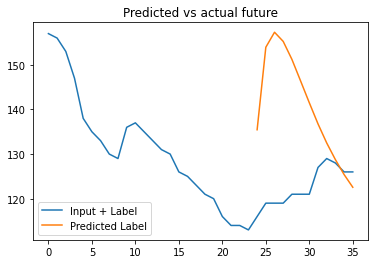

[Training:90] Total Loss: 6.55 Loss: 5.88: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


tensor([0.2949, 0.3583, 0.3824, 0.3958, 0.4060, 0.4149, 0.4240, 0.4324, 0.4403,
        0.4477, 0.4547, 0.4612], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4125, 0.4475, 0.4850, 0.5150, 0.5400, 0.5550, 0.5750, 0.5750, 0.5750,
        0.5775, 0.5775, 0.5775], device='cuda:0')


[Training:91] Total Loss: 6.49 Loss: 6.18: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.2644, 0.3078, 0.3093, 0.3001, 0.2878, 0.2747, 0.2620, 0.2506, 0.2414,
        0.2349, 0.2295, 0.2237], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.1925, 0.1925, 0.2050, 0.2075, 0.2025, 0.1975, 0.1975, 0.2050,
        0.2200, 0.2175, 0.2025], device='cuda:0')


[Training:92] Total Loss: 6.43 Loss: 6.47: 100%|██████████| 93/93 [00:19<00:00,  4.79it/s]


tensor([0.1944, 0.2478, 0.2554, 0.2499, 0.2399, 0.2284, 0.2173, 0.2079, 0.2007,
        0.1957, 0.1920, 0.1889], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2125, 0.2025, 0.1975, 0.1875, 0.1775, 0.1650, 0.1600, 0.1650, 0.1750,
        0.1850, 0.1900, 0.1875], device='cuda:0')


[Training:93] Total Loss: 6.37 Loss: 5.91: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.2677, 0.3199, 0.3325, 0.3345, 0.3334, 0.3314, 0.3294, 0.3276, 0.3259,
        0.3241, 0.3220, 0.3201], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3025, 0.3200, 0.3325, 0.3450, 0.3550, 0.3600, 0.3625, 0.3625, 0.3575,
        0.3500, 0.3425, 0.3400], device='cuda:0')


[Training:94] Total Loss: 6.31 Loss: 5.40: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.3959, 0.4488, 0.4650, 0.4679, 0.4650, 0.4594, 0.4524, 0.4446, 0.4366,
        0.4294, 0.4232, 0.4168], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4200, 0.4225, 0.4275, 0.4250, 0.4225, 0.4200, 0.4175, 0.4100, 0.4025,
        0.4075, 0.4100, 0.3975], device='cuda:0')


[Training:95] Total Loss: 6.26 Loss: 6.15: 100%|██████████| 93/93 [00:19<00:00,  4.73it/s]


tensor([0.3977, 0.4449, 0.4568, 0.4564, 0.4506, 0.4423, 0.4329, 0.4235, 0.4142,
        0.4053, 0.3975, 0.3913], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3950, 0.3975, 0.3925, 0.3850, 0.3775, 0.3750, 0.3725, 0.3725, 0.3700,
        0.3675, 0.3700, 0.3800], device='cuda:0')


[Training:96] Total Loss: 6.20 Loss: 5.97: 100%|██████████| 93/93 [00:19<00:00,  4.77it/s]


tensor([0.3633, 0.4101, 0.4160, 0.4106, 0.4011, 0.3892, 0.3769, 0.3659, 0.3556,
        0.3459, 0.3376, 0.3323], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3500, 0.3475, 0.3450, 0.3400, 0.3325, 0.3150, 0.3100, 0.3150, 0.3100,
        0.3025, 0.3075, 0.3300], device='cuda:0')


[Training:97] Total Loss: 6.15 Loss: 6.24: 100%|██████████| 93/93 [00:18<00:00,  5.08it/s]


tensor([0.3682, 0.4214, 0.4342, 0.4358, 0.4338, 0.4303, 0.4265, 0.4230, 0.4197,
        0.4169, 0.4139, 0.4116], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4175, 0.4200, 0.4250, 0.4300, 0.4350, 0.4350, 0.4350, 0.4375, 0.4350,
        0.4350, 0.4250, 0.4300], device='cuda:0')


[Training:98] Total Loss: 6.09 Loss: 6.30: 100%|██████████| 93/93 [00:18<00:00,  4.93it/s]


tensor([0.3841, 0.4577, 0.4908, 0.5079, 0.5182, 0.5250, 0.5303, 0.5349, 0.5388,
        0.5433, 0.5485, 0.5530], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5800, 0.5850, 0.5925, 0.6000, 0.6100, 0.6175, 0.6250, 0.6325, 0.6300,
        0.6475, 0.6625, 0.6500], device='cuda:0')


[Training:99] Total Loss: 6.04 Loss: 6.10: 100%|██████████| 93/93 [00:19<00:00,  4.72it/s]


tensor([0.4003, 0.4617, 0.4848, 0.4939, 0.4976, 0.4982, 0.4972, 0.4955, 0.4938,
        0.4919, 0.4901, 0.4883], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5050, 0.5050, 0.5025, 0.5025, 0.5125, 0.5125, 0.5125, 0.5150, 0.5175,
        0.5150, 0.5125, 0.5100], device='cuda:0')


[Training:100] Total Loss: 5.99 Loss: 5.94: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.2778, 0.3482, 0.3690, 0.3711, 0.3658, 0.3579, 0.3493, 0.3407, 0.3324,
        0.3244, 0.3175, 0.3123], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3600, 0.3400, 0.3300, 0.3250, 0.3225, 0.3225, 0.3200, 0.3150, 0.3075,
        0.3000, 0.3000, 0.3100], device='cuda:0')


[Training:101] Total Loss: 5.94 Loss: 6.09: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.3504, 0.4141, 0.4383, 0.4472, 0.4498, 0.4495, 0.4485, 0.4467, 0.4446,
        0.4431, 0.4423, 0.4422], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4450, 0.4500, 0.4575, 0.4600, 0.4650, 0.4700, 0.4775, 0.4700, 0.4675,
        0.4725, 0.4775, 0.4800], device='cuda:0')


[Training:102] Total Loss: 5.89 Loss: 6.72: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.3225, 0.3809, 0.3992, 0.4032, 0.4011, 0.3960, 0.3891, 0.3813, 0.3738,
        0.3671, 0.3617, 0.3573], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3425, 0.3525, 0.3625, 0.3700, 0.3725, 0.3700, 0.3625, 0.3550, 0.3525,
        0.3550, 0.3600, 0.3625], device='cuda:0')


[Training:103] Total Loss: 5.84 Loss: 6.18: 100%|██████████| 93/93 [00:18<00:00,  4.97it/s]


tensor([0.2865, 0.3521, 0.3748, 0.3815, 0.3815, 0.3789, 0.3755, 0.3721, 0.3687,
        0.3653, 0.3617, 0.3579], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3400, 0.3525, 0.3650, 0.3700, 0.3750, 0.3825, 0.3875, 0.3900, 0.3875,
        0.3800, 0.3725, 0.3625], device='cuda:0')


[Training:104] Total Loss: 5.79 Loss: 5.81: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.3389, 0.3926, 0.4023, 0.3994, 0.3911, 0.3799, 0.3677, 0.3563, 0.3457,
        0.3350, 0.3241, 0.3142], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4075, 0.3950, 0.3800, 0.3675, 0.3450, 0.3200, 0.3050, 0.3025, 0.2975,
        0.2825, 0.2675, 0.2675], device='cuda:0')


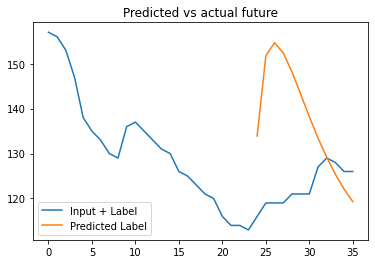

[Training:105] Total Loss: 5.74 Loss: 5.46: 100%|██████████| 93/93 [00:18<00:00,  5.03it/s]


tensor([0.2638, 0.3133, 0.3222, 0.3206, 0.3167, 0.3132, 0.3109, 0.3099, 0.3104,
        0.3124, 0.3156, 0.3197], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3025, 0.3050, 0.3100, 0.3175, 0.3275, 0.3400, 0.3500, 0.3575, 0.3675,
        0.3800, 0.3900, 0.3975], device='cuda:0')


[Training:106] Total Loss: 5.70 Loss: 6.62: 100%|██████████| 93/93 [00:18<00:00,  5.08it/s]


tensor([0.4423, 0.5055, 0.5280, 0.5372, 0.5407, 0.5410, 0.5398, 0.5376, 0.5357,
        0.5337, 0.5308, 0.5273], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6000, 0.6025, 0.6050, 0.5900, 0.5750, 0.5625, 0.5575, 0.5450, 0.5525,
        0.5450, 0.5275, 0.5200], device='cuda:0')


[Training:107] Total Loss: 5.66 Loss: 5.94: 100%|██████████| 93/93 [00:18<00:00,  5.04it/s]


tensor([0.3048, 0.3714, 0.3919, 0.3945, 0.3902, 0.3835, 0.3763, 0.3700, 0.3652,
        0.3618, 0.3597, 0.3584], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3925, 0.3725, 0.3500, 0.3400, 0.3425, 0.3500, 0.3550, 0.3650, 0.3750,
        0.3825, 0.3900, 0.3900], device='cuda:0')


[Training:108] Total Loss: 5.61 Loss: 5.57: 100%|██████████| 93/93 [00:17<00:00,  5.33it/s]


tensor([0.4398, 0.4903, 0.5073, 0.5118, 0.5095, 0.5027, 0.4938, 0.4839, 0.4733,
        0.4629, 0.4531, 0.4440], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5125, 0.5025, 0.4925, 0.4800, 0.4550, 0.4325, 0.4225, 0.4150, 0.4025,
        0.4000, 0.3975, 0.3950], device='cuda:0')


[Training:109] Total Loss: 5.57 Loss: 5.47: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.4668, 0.5344, 0.5626, 0.5777, 0.5870, 0.5932, 0.5980, 0.6026, 0.6074,
        0.6131, 0.6193, 0.6254], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6800, 0.6750, 0.6975, 0.6875, 0.6825, 0.6775, 0.6800, 0.6925, 0.7025,
        0.7250, 0.7400, 0.7400], device='cuda:0')


[Training:110] Total Loss: 5.53 Loss: 5.64: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.2910, 0.3614, 0.3831, 0.3858, 0.3810, 0.3733, 0.3657, 0.3589, 0.3532,
        0.3487, 0.3455, 0.3436], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3575, 0.3550, 0.3500, 0.3475, 0.3475, 0.3450, 0.3500, 0.3525, 0.3550,
        0.3575, 0.3625, 0.3700], device='cuda:0')


[Training:111] Total Loss: 5.49 Loss: 5.75: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.0504, 0.1210, 0.1489, 0.1685, 0.1855, 0.2010, 0.2156, 0.2298, 0.2438,
        0.2575, 0.2707, 0.2829], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2525, 0.2775, 0.2975, 0.3575, 0.3825, 0.3925, 0.3975, 0.4050, 0.4125,
        0.4200, 0.4250, 0.4250], device='cuda:0')


[Training:112] Total Loss: 5.45 Loss: 5.49: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3584, 0.4107, 0.4249, 0.4244, 0.4177, 0.4082, 0.3975, 0.3869, 0.3766,
        0.3662, 0.3564, 0.3468], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3800, 0.3800, 0.3700, 0.3600, 0.3550, 0.3500, 0.3425, 0.3400, 0.3325,
        0.3200, 0.3150, 0.3050], device='cuda:0')


[Training:113] Total Loss: 5.41 Loss: 5.52: 100%|██████████| 93/93 [00:18<00:00,  4.97it/s]


tensor([0.4176, 0.4830, 0.5063, 0.5145, 0.5161, 0.5144, 0.5105, 0.5047, 0.4981,
        0.4910, 0.4839, 0.4775], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5750, 0.5700, 0.5675, 0.5425, 0.5250, 0.5125, 0.4925, 0.4725, 0.4600,
        0.4475, 0.4425, 0.4425], device='cuda:0')


[Training:114] Total Loss: 5.37 Loss: 5.06: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.1892, 0.2423, 0.2561, 0.2597, 0.2600, 0.2606, 0.2620, 0.2636, 0.2643,
        0.2643, 0.2634, 0.2609], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2950, 0.2925, 0.3075, 0.3100, 0.3075, 0.3225, 0.3300, 0.3300, 0.3175,
        0.3075, 0.2950, 0.2750], device='cuda:0')


[Training:115] Total Loss: 5.33 Loss: 5.86: 100%|██████████| 93/93 [00:18<00:00,  5.14it/s]


tensor([0.3750, 0.4186, 0.4274, 0.4242, 0.4161, 0.4053, 0.3917, 0.3771, 0.3631,
        0.3501, 0.3396, 0.3292], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3550, 0.3500, 0.3450, 0.3375, 0.3325, 0.3250, 0.3000, 0.2900, 0.2875,
        0.2875, 0.3000, 0.2850], device='cuda:0')


[Training:116] Total Loss: 5.29 Loss: 5.00: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.4305, 0.4746, 0.4875, 0.4890, 0.4845, 0.4766, 0.4664, 0.4552, 0.4442,
        0.4338, 0.4238, 0.4142], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4425, 0.4450, 0.4475, 0.4350, 0.4175, 0.4025, 0.3875, 0.3800, 0.3775,
        0.3750, 0.3700, 0.3650], device='cuda:0')


[Training:117] Total Loss: 5.26 Loss: 5.32: 100%|██████████| 93/93 [00:18<00:00,  5.12it/s]


tensor([0.3190, 0.3639, 0.3657, 0.3556, 0.3416, 0.3261, 0.3113, 0.2980, 0.2865,
        0.2764, 0.2674, 0.2592], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2975, 0.2875, 0.2750, 0.2675, 0.2600, 0.2475, 0.2450, 0.2450, 0.2475,
        0.2450, 0.2425, 0.2375], device='cuda:0')


[Training:118] Total Loss: 5.22 Loss: 5.02: 100%|██████████| 93/93 [00:18<00:00,  5.10it/s]


tensor([0.4016, 0.4407, 0.4356, 0.4169, 0.3930, 0.3685, 0.3463, 0.3271, 0.3121,
        0.3002, 0.2912, 0.2846], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3200, 0.2850, 0.2475, 0.2250, 0.2050, 0.2025, 0.2125, 0.2250, 0.2475,
        0.2600, 0.2725, 0.2825], device='cuda:0')


[Training:119] Total Loss: 5.19 Loss: 4.90: 100%|██████████| 93/93 [00:17<00:00,  5.18it/s]

tensor([0.3302, 0.3753, 0.3810, 0.3769, 0.3705, 0.3638, 0.3574, 0.3509, 0.3447,
        0.3398, 0.3375, 0.3379], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3275, 0.3375, 0.3350, 0.3425, 0.3525, 0.3550, 0.3550, 0.3450, 0.3400,
        0.3450, 0.3650, 0.3875], device='cuda:0')


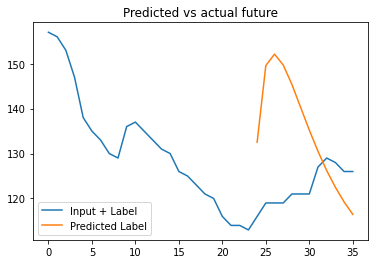

[Training:120] Total Loss: 5.15 Loss: 4.55: 100%|██████████| 93/93 [00:18<00:00,  5.10it/s]


tensor([0.2638, 0.3151, 0.3260, 0.3231, 0.3153, 0.3066, 0.3020, 0.2995, 0.2991,
        0.3014, 0.3076, 0.3166], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2225, 0.2350, 0.2450, 0.2525, 0.2600, 0.2750, 0.3250, 0.3425, 0.3600,
        0.3850, 0.4225, 0.4500], device='cuda:0')


[Training:121] Total Loss: 5.12 Loss: 5.60: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.4190, 0.4608, 0.4619, 0.4519, 0.4377, 0.4217, 0.4052, 0.3886, 0.3726,
        0.3572, 0.3426, 0.3293], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3825, 0.3675, 0.3525, 0.3425, 0.3300, 0.3150, 0.3050, 0.2900, 0.2825,
        0.2725, 0.2650, 0.2625], device='cuda:0')


[Training:122] Total Loss: 5.09 Loss: 4.97: 100%|██████████| 93/93 [00:18<00:00,  5.14it/s]


tensor([0.3380, 0.4031, 0.4278, 0.4374, 0.4407, 0.4414, 0.4412, 0.4409, 0.4431,
        0.4491, 0.4565, 0.4640], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4400, 0.4400, 0.4450, 0.4525, 0.4600, 0.4675, 0.4700, 0.4725, 0.5050,
        0.5450, 0.5575, 0.5575], device='cuda:0')


[Training:123] Total Loss: 5.05 Loss: 4.91: 100%|██████████| 93/93 [00:18<00:00,  5.13it/s]


tensor([0.3821, 0.4427, 0.4652, 0.4734, 0.4751, 0.4734, 0.4699, 0.4663, 0.4622,
        0.4576, 0.4540, 0.4508], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5050, 0.4975, 0.4875, 0.4800, 0.4725, 0.4650, 0.4575, 0.4600, 0.4500,
        0.4400, 0.4475, 0.4450], device='cuda:0')


[Training:124] Total Loss: 5.02 Loss: 4.60: 100%|██████████| 93/93 [00:18<00:00,  5.07it/s]


tensor([0.2122, 0.2894, 0.3207, 0.3366, 0.3474, 0.3566, 0.3654, 0.3743, 0.3829,
        0.3926, 0.4035, 0.4143], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4150, 0.4100, 0.4250, 0.4375, 0.4575, 0.4750, 0.4875, 0.4950, 0.4975,
        0.5150, 0.5325, 0.5375], device='cuda:0')


[Training:125] Total Loss: 5.00 Loss: 5.33: 100%|██████████| 93/93 [00:18<00:00,  5.12it/s]


tensor([0.3748, 0.4187, 0.4218, 0.4116, 0.3960, 0.3786, 0.3601, 0.3404, 0.3193,
        0.2978, 0.2769, 0.2575], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3700, 0.3475, 0.3300, 0.3050, 0.2825, 0.2725, 0.2525, 0.2250, 0.1950,
        0.1725, 0.1575, 0.1500], device='cuda:0')


[Training:126] Total Loss: 4.96 Loss: 4.67: 100%|██████████| 93/93 [00:17<00:00,  5.17it/s]


tensor([0.3360, 0.3738, 0.3717, 0.3577, 0.3406, 0.3248, 0.3103, 0.2970, 0.2847,
        0.2724, 0.2608, 0.2501], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2925, 0.2900, 0.2700, 0.2450, 0.2400, 0.2525, 0.2525, 0.2475, 0.2425,
        0.2250, 0.2175, 0.2125], device='cuda:0')


[Training:127] Total Loss: 4.94 Loss: 5.57: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3145, 0.3764, 0.3969, 0.4020, 0.4006, 0.3967, 0.3921, 0.3881, 0.3855,
        0.3844, 0.3842, 0.3847], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3700, 0.3725, 0.3750, 0.3800, 0.3825, 0.3875, 0.3925, 0.4000, 0.4100,
        0.4200, 0.4225, 0.4250], device='cuda:0')


[Training:128] Total Loss: 4.91 Loss: 4.61: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.3316, 0.3759, 0.3833, 0.3773, 0.3661, 0.3529, 0.3393, 0.3265, 0.3151,
        0.3052, 0.2965, 0.2886], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3000, 0.2975, 0.2925, 0.2875, 0.2875, 0.2825, 0.2800, 0.2775, 0.2800,
        0.2800, 0.2775, 0.2750], device='cuda:0')


[Training:129] Total Loss: 4.88 Loss: 4.50: 100%|██████████| 93/93 [00:18<00:00,  4.97it/s]


tensor([0.3607, 0.4372, 0.4718, 0.4893, 0.4993, 0.5058, 0.5105, 0.5146, 0.5181,
        0.5212, 0.5242, 0.5274], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5500, 0.5525, 0.5525, 0.5525, 0.5575, 0.5625, 0.5650, 0.5675, 0.5650,
        0.5625, 0.5625, 0.5650], device='cuda:0')


[Training:130] Total Loss: 4.85 Loss: 4.57: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.3807, 0.4406, 0.4596, 0.4629, 0.4575, 0.4477, 0.4346, 0.4192, 0.4020,
        0.3850, 0.3693, 0.3579], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5150, 0.5050, 0.4975, 0.4500, 0.4050, 0.3775, 0.3450, 0.3150, 0.2875,
        0.2800, 0.2775, 0.3100], device='cuda:0')


[Training:131] Total Loss: 4.83 Loss: 5.23: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.3217, 0.3736, 0.3851, 0.3851, 0.3802, 0.3716, 0.3605, 0.3483, 0.3356,
        0.3231, 0.3108, 0.2990], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4225, 0.4150, 0.4050, 0.3900, 0.3675, 0.3350, 0.3075, 0.2875, 0.2725,
        0.2625, 0.2525, 0.2450], device='cuda:0')


[Training:132] Total Loss: 4.80 Loss: 5.08: 100%|██████████| 93/93 [00:18<00:00,  4.92it/s]


tensor([0.3183, 0.3641, 0.3721, 0.3674, 0.3575, 0.3445, 0.3307, 0.3180, 0.3063,
        0.2950, 0.2848, 0.2759], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2900, 0.2950, 0.2850, 0.2875, 0.2850, 0.2725, 0.2675, 0.2725, 0.2700,
        0.2600, 0.2575, 0.2575], device='cuda:0')


[Training:133] Total Loss: 4.77 Loss: 5.34: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.3497, 0.3999, 0.4100, 0.4080, 0.4007, 0.3911, 0.3806, 0.3694, 0.3584,
        0.3475, 0.3361, 0.3248], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4100, 0.4025, 0.3950, 0.3800, 0.3625, 0.3475, 0.3350, 0.3200, 0.3100,
        0.3000, 0.2825, 0.2725], device='cuda:0')


[Training:134] Total Loss: 4.75 Loss: 4.84: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]

tensor([0.3368, 0.3926, 0.4077, 0.4071, 0.3994, 0.3879, 0.3746, 0.3604, 0.3457,
        0.3308, 0.3162, 0.3019], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3675, 0.3575, 0.3475, 0.3375, 0.3275, 0.3150, 0.3025, 0.2900, 0.2750,
        0.2600, 0.2475, 0.2350], device='cuda:0')


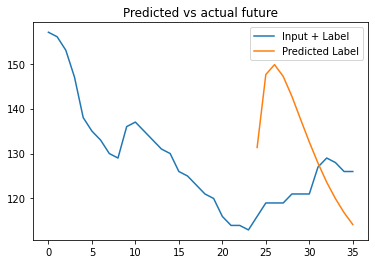

[Training:135] Total Loss: 4.72 Loss: 4.37: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.2294, 0.2793, 0.2909, 0.2897, 0.2847, 0.2789, 0.2793, 0.2839, 0.2917,
        0.3020, 0.3135, 0.3253], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.2300, 0.2500, 0.2625, 0.2800, 0.2900, 0.3600, 0.3950, 0.4250,
        0.4500, 0.4625, 0.4675], device='cuda:0')


[Training:136] Total Loss: 4.70 Loss: 4.48: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.2741, 0.3163, 0.3202, 0.3110, 0.2971, 0.2818, 0.2667, 0.2527, 0.2400,
        0.2287, 0.2187, 0.2102], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2175, 0.2175, 0.2150, 0.2125, 0.2100, 0.2100, 0.2075, 0.2075, 0.2050,
        0.2025, 0.2000, 0.2000], device='cuda:0')


[Training:137] Total Loss: 4.68 Loss: 4.73: 100%|██████████| 93/93 [00:18<00:00,  5.05it/s]


tensor([0.4312, 0.4826, 0.4955, 0.4975, 0.4963, 0.4938, 0.4911, 0.4886, 0.4866,
        0.4852, 0.4839, 0.4833], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4850, 0.4825, 0.4825, 0.4800, 0.4850, 0.4850, 0.4850, 0.4850, 0.4875,
        0.4875, 0.4850, 0.4900], device='cuda:0')


[Training:138] Total Loss: 4.65 Loss: 4.39: 100%|██████████| 93/93 [00:19<00:00,  4.70it/s]


tensor([0.5213, 0.5899, 0.6195, 0.6374, 0.6502, 0.6604, 0.6687, 0.6759, 0.6823,
        0.6880, 0.6927, 0.6965], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7300, 0.7350, 0.7400, 0.7475, 0.7525, 0.7525, 0.7525, 0.7525, 0.7525,
        0.7500, 0.7450, 0.7375], device='cuda:0')


[Training:139] Total Loss: 4.63 Loss: 4.55: 100%|██████████| 93/93 [00:19<00:00,  4.83it/s]


tensor([0.2444, 0.2909, 0.3010, 0.3000, 0.2953, 0.2907, 0.2868, 0.2835, 0.2820,
        0.2824, 0.2850, 0.2897], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2925, 0.2725, 0.2650, 0.2750, 0.2850, 0.3050, 0.3150, 0.3200, 0.3325,
        0.3450, 0.3625, 0.3800], device='cuda:0')


[Training:140] Total Loss: 4.61 Loss: 4.64: 100%|██████████| 93/93 [00:19<00:00,  4.68it/s]


tensor([0.5257, 0.5911, 0.6180, 0.6319, 0.6384, 0.6389, 0.6352, 0.6295, 0.6233,
        0.6175, 0.6126, 0.6091], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7225, 0.7150, 0.7075, 0.6900, 0.6550, 0.6075, 0.5725, 0.5550, 0.5500,
        0.5525, 0.5575, 0.5700], device='cuda:0')


[Training:141] Total Loss: 4.59 Loss: 4.65: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.4316, 0.4944, 0.5177, 0.5297, 0.5372, 0.5419, 0.5444, 0.5456, 0.5458,
        0.5468, 0.5485, 0.5499], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6000, 0.6000, 0.5975, 0.5975, 0.5950, 0.5825, 0.5650, 0.5550, 0.5450,
        0.5550, 0.5625, 0.5550], device='cuda:0')


[Training:142] Total Loss: 4.56 Loss: 4.80: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3107, 0.3629, 0.3761, 0.3753, 0.3685, 0.3595, 0.3502, 0.3414, 0.3333,
        0.3264, 0.3209, 0.3165], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3450, 0.3375, 0.3350, 0.3350, 0.3300, 0.3275, 0.3250, 0.3225, 0.3200,
        0.3200, 0.3250, 0.3250], device='cuda:0')


[Training:143] Total Loss: 4.54 Loss: 4.49: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.2921, 0.3280, 0.3266, 0.3153, 0.3022, 0.2897, 0.2787, 0.2693, 0.2614,
        0.2548, 0.2494, 0.2456], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2450, 0.2450, 0.2400, 0.2375, 0.2450, 0.2525, 0.2575, 0.2600, 0.2625,
        0.2625, 0.2625, 0.2700], device='cuda:0')


[Training:144] Total Loss: 4.52 Loss: 4.58: 100%|██████████| 93/93 [00:18<00:00,  5.02it/s]


tensor([0.4407, 0.5079, 0.5392, 0.5566, 0.5661, 0.5723, 0.5766, 0.5798, 0.5818,
        0.5823, 0.5804, 0.5763], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6350, 0.6225, 0.6150, 0.6125, 0.5925, 0.6000, 0.5975, 0.5975, 0.5900,
        0.5750, 0.5450, 0.5200], device='cuda:0')


[Training:145] Total Loss: 4.50 Loss: 4.36: 100%|██████████| 93/93 [00:18<00:00,  5.04it/s]


tensor([0.3051, 0.3521, 0.3611, 0.3556, 0.3442, 0.3317, 0.3204, 0.3106, 0.3019,
        0.2954, 0.2918, 0.2905], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3000, 0.3000, 0.2925, 0.2800, 0.2750, 0.2800, 0.2900, 0.2950, 0.2925,
        0.3025, 0.3200, 0.3325], device='cuda:0')


[Training:146] Total Loss: 4.48 Loss: 3.72: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.3531, 0.4249, 0.4540, 0.4663, 0.4716, 0.4741, 0.4756, 0.4773, 0.4793,
        0.4827, 0.4882, 0.4947], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4775, 0.4825, 0.4875, 0.4900, 0.4950, 0.5000, 0.5050, 0.5100, 0.5125,
        0.5275, 0.5500, 0.5600], device='cuda:0')


[Training:147] Total Loss: 4.46 Loss: 3.97: 100%|██████████| 93/93 [00:18<00:00,  5.00it/s]


tensor([0.2629, 0.2964, 0.2938, 0.2830, 0.2708, 0.2591, 0.2491, 0.2407, 0.2339,
        0.2288, 0.2253, 0.2228], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2150, 0.2250, 0.2250, 0.2275, 0.2325, 0.2350, 0.2400, 0.2425, 0.2450,
        0.2500, 0.2550, 0.2575], device='cuda:0')


[Training:148] Total Loss: 4.44 Loss: 4.59: 100%|██████████| 93/93 [00:18<00:00,  4.98it/s]


tensor([0.2910, 0.3265, 0.3318, 0.3287, 0.3235, 0.3191, 0.3164, 0.3151, 0.3162,
        0.3197, 0.3245, 0.3313], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2300, 0.2475, 0.2750, 0.2950, 0.3125, 0.3350, 0.3525, 0.3625, 0.3825,
        0.4000, 0.4100, 0.4300], device='cuda:0')


[Training:149] Total Loss: 4.43 Loss: 4.64: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.2523, 0.3074, 0.3289, 0.3397, 0.3467, 0.3513, 0.3544, 0.3565, 0.3579,
        0.3593, 0.3626, 0.3677], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3450, 0.3650, 0.3850, 0.4050, 0.4225, 0.4250, 0.4225, 0.4150, 0.4100,
        0.4075, 0.4275, 0.4425], device='cuda:0')


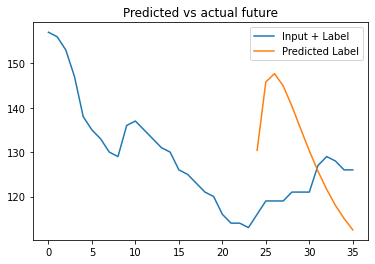

[Training:150] Total Loss: 4.41 Loss: 4.46: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.2889, 0.3249, 0.3212, 0.3033, 0.2802, 0.2563, 0.2327, 0.2110, 0.1912,
        0.1730, 0.1579, 0.1458], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1950, 0.1775, 0.1625, 0.1500, 0.1400, 0.1350, 0.1225, 0.1175, 0.1100,
        0.1000, 0.1050, 0.1125], device='cuda:0')


[Training:151] Total Loss: 4.39 Loss: 4.30: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.4164, 0.4699, 0.4897, 0.4958, 0.4939, 0.4878, 0.4794, 0.4700, 0.4601,
        0.4497, 0.4394, 0.4300], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5000, 0.4925, 0.4875, 0.4700, 0.4425, 0.4275, 0.4150, 0.4050, 0.3950,
        0.3825, 0.3750, 0.3750], device='cuda:0')


[Training:152] Total Loss: 4.37 Loss: 4.69: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.3881, 0.4534, 0.4783, 0.4875, 0.4898, 0.4895, 0.4876, 0.4853, 0.4833,
        0.4812, 0.4787, 0.4760], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5025, 0.4875, 0.4825, 0.4750, 0.4750, 0.4800, 0.4775, 0.4775, 0.4800,
        0.4750, 0.4650, 0.4600], device='cuda:0')


[Training:153] Total Loss: 4.35 Loss: 4.21: 100%|██████████| 93/93 [00:18<00:00,  4.98it/s]


tensor([0.2650, 0.2963, 0.2915, 0.2775, 0.2599, 0.2417, 0.2247, 0.2105, 0.2018,
        0.1984, 0.1990, 0.2011], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2000, 0.1900, 0.1950, 0.1925, 0.1775, 0.1675, 0.1650, 0.1725, 0.2075,
        0.2425, 0.2700, 0.2775], device='cuda:0')


[Training:154] Total Loss: 4.34 Loss: 4.56: 100%|██████████| 93/93 [00:18<00:00,  4.93it/s]


tensor([0.2860, 0.3156, 0.3075, 0.2899, 0.2705, 0.2519, 0.2383, 0.2306, 0.2286,
        0.2269, 0.2276, 0.2304], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2000, 0.1950, 0.1875, 0.1800, 0.1775, 0.1775, 0.2100, 0.2475, 0.2875,
        0.2775, 0.2950, 0.3100], device='cuda:0')


[Training:155] Total Loss: 4.32 Loss: 4.64: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.2804, 0.3316, 0.3444, 0.3446, 0.3400, 0.3338, 0.3277, 0.3224, 0.3186,
        0.3166, 0.3160, 0.3162], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3050, 0.3000, 0.3050, 0.3150, 0.3225, 0.3275, 0.3325, 0.3375, 0.3450,
        0.3550, 0.3600, 0.3625], device='cuda:0')


[Training:156] Total Loss: 4.30 Loss: 3.94: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3209, 0.3663, 0.3737, 0.3705, 0.3639, 0.3570, 0.3504, 0.3446, 0.3399,
        0.3360, 0.3325, 0.3294], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3500, 0.3500, 0.3475, 0.3450, 0.3500, 0.3475, 0.3475, 0.3500,
        0.3475, 0.3450, 0.3425], device='cuda:0')


[Training:157] Total Loss: 4.29 Loss: 4.79: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.3490, 0.3899, 0.3941, 0.3891, 0.3814, 0.3728, 0.3639, 0.3550, 0.3468,
        0.3406, 0.3362, 0.3327], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3500, 0.3500, 0.3475, 0.3475, 0.3475, 0.3450, 0.3375, 0.3300, 0.3275,
        0.3375, 0.3450, 0.3450], device='cuda:0')


[Training:158] Total Loss: 4.27 Loss: 4.01: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.2268, 0.3152, 0.3623, 0.3947, 0.4211, 0.4455, 0.4675, 0.4876, 0.5086,
        0.5301, 0.5516, 0.5723], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6100, 0.6175, 0.6250, 0.6300, 0.6425, 0.6650, 0.6600, 0.6625, 0.6950,
        0.7175, 0.7375, 0.7475], device='cuda:0')


[Training:159] Total Loss: 4.26 Loss: 4.15: 100%|██████████| 93/93 [00:18<00:00,  5.11it/s]


tensor([0.2798, 0.3477, 0.3721, 0.3782, 0.3752, 0.3670, 0.3563, 0.3446, 0.3320,
        0.3194, 0.3071, 0.2951], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4225, 0.4175, 0.4025, 0.3825, 0.3600, 0.3350, 0.3150, 0.3000, 0.2800,
        0.2675, 0.2575, 0.2475], device='cuda:0')


[Training:160] Total Loss: 4.24 Loss: 4.18: 100%|██████████| 93/93 [00:18<00:00,  5.07it/s]


tensor([0.4629, 0.5192, 0.5380, 0.5451, 0.5477, 0.5478, 0.5463, 0.5440, 0.5414,
        0.5385, 0.5358, 0.5336], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5650, 0.5575, 0.5550, 0.5475, 0.5450, 0.5350, 0.5250, 0.5175, 0.5125,
        0.5050, 0.5050, 0.5050], device='cuda:0')


[Training:161] Total Loss: 4.22 Loss: 3.88: 100%|██████████| 93/93 [00:18<00:00,  5.07it/s]


tensor([0.5414, 0.5910, 0.6139, 0.6267, 0.6345, 0.6383, 0.6396, 0.6390, 0.6367,
        0.6327, 0.6298, 0.6279], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6850, 0.6775, 0.6625, 0.6500, 0.6400, 0.6225, 0.6100, 0.5975, 0.5825,
        0.5650, 0.5825, 0.5875], device='cuda:0')


[Training:162] Total Loss: 4.21 Loss: 4.19: 100%|██████████| 93/93 [00:18<00:00,  5.10it/s]


tensor([0.4963, 0.5611, 0.5866, 0.5991, 0.6061, 0.6104, 0.6134, 0.6155, 0.6168,
        0.6171, 0.6178, 0.6180], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6425, 0.6425, 0.6350, 0.6300, 0.6250, 0.6200, 0.6175, 0.6125, 0.6050,
        0.5950, 0.6000, 0.5925], device='cuda:0')


[Training:163] Total Loss: 4.19 Loss: 4.11: 100%|██████████| 93/93 [00:18<00:00,  4.98it/s]


tensor([0.4586, 0.5128, 0.5356, 0.5483, 0.5549, 0.5568, 0.5543, 0.5484, 0.5398,
        0.5276, 0.5138, 0.4995], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5550, 0.5550, 0.5550, 0.5750, 0.5650, 0.5425, 0.5100, 0.4800, 0.4525,
        0.4100, 0.3925, 0.3800], device='cuda:0')


[Training:164] Total Loss: 4.18 Loss: 4.45: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]

tensor([0.2639, 0.2852, 0.2735, 0.2555, 0.2369, 0.2212, 0.2069, 0.1971, 0.1957,
        0.2018, 0.2120, 0.2249], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1425, 0.1250, 0.1475, 0.1575, 0.1600, 0.1775, 0.1725, 0.1975, 0.2625,
        0.3250, 0.3600, 0.3875], device='cuda:0')


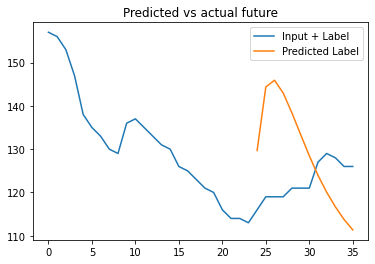

[Training:165] Total Loss: 4.17 Loss: 3.95: 100%|██████████| 93/93 [00:18<00:00,  5.08it/s]


tensor([0.3132, 0.3401, 0.3361, 0.3234, 0.3086, 0.2943, 0.2816, 0.2708, 0.2622,
        0.2563, 0.2525, 0.2508], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2150, 0.2150, 0.2125, 0.2175, 0.2250, 0.2350, 0.2450, 0.2525, 0.2625,
        0.2750, 0.2850, 0.2950], device='cuda:0')


[Training:166] Total Loss: 4.15 Loss: 4.04: 100%|██████████| 93/93 [00:18<00:00,  5.12it/s]


tensor([0.5382, 0.5849, 0.6035, 0.6109, 0.6122, 0.6096, 0.6043, 0.5961, 0.5849,
        0.5713, 0.5562, 0.5402], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6275, 0.6100, 0.5950, 0.5775, 0.5600, 0.5425, 0.5225, 0.4950, 0.4625,
        0.4325, 0.4125, 0.3950], device='cuda:0')


[Training:167] Total Loss: 4.14 Loss: 4.12: 100%|██████████| 93/93 [00:18<00:00,  5.09it/s]


tensor([0.4085, 0.4540, 0.4714, 0.4806, 0.4873, 0.4933, 0.5000, 0.5079, 0.5158,
        0.5245, 0.5341, 0.5449], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4575, 0.4550, 0.4775, 0.5000, 0.5225, 0.5375, 0.5600, 0.5800, 0.5825,
        0.5975, 0.6125, 0.6300], device='cuda:0')


[Training:168] Total Loss: 4.12 Loss: 3.94: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.2631, 0.3070, 0.3159, 0.3199, 0.3225, 0.3245, 0.3282, 0.3350, 0.3437,
        0.3542, 0.3658, 0.3780], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2900, 0.3150, 0.3375, 0.3825, 0.3925, 0.3950, 0.4125, 0.4400, 0.4575,
        0.4750, 0.4875, 0.5000], device='cuda:0')


[Training:169] Total Loss: 4.11 Loss: 4.27: 100%|██████████| 93/93 [00:18<00:00,  5.00it/s]


tensor([0.3001, 0.3235, 0.3132, 0.2957, 0.2780, 0.2625, 0.2500, 0.2402, 0.2330,
        0.2280, 0.2243, 0.2215], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.2000, 0.1975, 0.1950, 0.2000, 0.2125, 0.2250, 0.2350, 0.2450,
        0.2525, 0.2550, 0.2550], device='cuda:0')


[Training:170] Total Loss: 4.10 Loss: 4.20: 100%|██████████| 93/93 [00:18<00:00,  5.06it/s]


tensor([0.3699, 0.4190, 0.4337, 0.4361, 0.4320, 0.4239, 0.4132, 0.4006, 0.3873,
        0.3721, 0.3556, 0.3393], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4275, 0.4200, 0.4075, 0.4050, 0.3900, 0.3725, 0.3525, 0.3325, 0.3175,
        0.2875, 0.2650, 0.2525], device='cuda:0')


[Training:171] Total Loss: 4.09 Loss: 4.25: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.2879, 0.3236, 0.3240, 0.3158, 0.3057, 0.2960, 0.2877, 0.2814, 0.2769,
        0.2739, 0.2722, 0.2717], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2725, 0.2725, 0.2750, 0.2775, 0.2800, 0.2825, 0.2875, 0.2950, 0.3000,
        0.3050, 0.3100, 0.3150], device='cuda:0')


[Training:172] Total Loss: 4.07 Loss: 4.12: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.3555, 0.4022, 0.4157, 0.4175, 0.4146, 0.4097, 0.4049, 0.4007, 0.3974,
        0.3948, 0.3924, 0.3908], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3800, 0.3875, 0.3900, 0.3925, 0.3950, 0.3950, 0.4000, 0.4025, 0.4050,
        0.4050, 0.4000, 0.4025], device='cuda:0')


[Training:173] Total Loss: 4.06 Loss: 4.41: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]


tensor([0.2791, 0.3202, 0.3252, 0.3177, 0.3058, 0.2925, 0.2802, 0.2692, 0.2575,
        0.2464, 0.2410, 0.2373], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2525, 0.2525, 0.2525, 0.2525, 0.2525, 0.2500, 0.2525, 0.2525, 0.2300,
        0.2225, 0.2625, 0.2650], device='cuda:0')


[Training:174] Total Loss: 4.05 Loss: 4.27: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.4169, 0.4931, 0.5365, 0.5678, 0.5953, 0.6203, 0.6435, 0.6652, 0.6854,
        0.7036, 0.7198, 0.7338], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6700, 0.6950, 0.7225, 0.7475, 0.7950, 0.8175, 0.8375, 0.8575, 0.8650,
        0.8700, 0.8650, 0.8600], device='cuda:0')


[Training:175] Total Loss: 4.04 Loss: 4.08: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s]


tensor([0.4110, 0.4586, 0.4705, 0.4730, 0.4723, 0.4703, 0.4684, 0.4670, 0.4663,
        0.4656, 0.4652, 0.4640], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4650, 0.4650, 0.4675, 0.4675, 0.4675, 0.4650, 0.4675, 0.4700, 0.4725,
        0.4675, 0.4675, 0.4550], device='cuda:0')


[Training:176] Total Loss: 4.02 Loss: 4.26: 100%|██████████| 93/93 [00:19<00:00,  4.71it/s]


tensor([0.3648, 0.4153, 0.4300, 0.4315, 0.4278, 0.4226, 0.4173, 0.4114, 0.4052,
        0.3991, 0.3938, 0.3889], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4175, 0.4075, 0.3975, 0.3950, 0.3975, 0.4025, 0.4050, 0.3950, 0.3850,
        0.3800, 0.3800, 0.3750], device='cuda:0')


[Training:177] Total Loss: 4.01 Loss: 4.04: 100%|██████████| 93/93 [00:18<00:00,  5.08it/s]


tensor([0.2860, 0.3484, 0.3747, 0.3891, 0.3991, 0.4071, 0.4136, 0.4191, 0.4247,
        0.4316, 0.4410, 0.4521], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3900, 0.4000, 0.4350, 0.4650, 0.4850, 0.4950, 0.4925, 0.4875, 0.4900,
        0.5050, 0.5325, 0.5500], device='cuda:0')


[Training:178] Total Loss: 4.00 Loss: 4.20: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.2807, 0.3199, 0.3180, 0.3018, 0.2807, 0.2587, 0.2381, 0.2202, 0.2066,
        0.1981, 0.1945, 0.1941], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2375, 0.2175, 0.1875, 0.1750, 0.1675, 0.1600, 0.1575, 0.1600, 0.1775,
        0.2050, 0.2350, 0.2525], device='cuda:0')


[Training:179] Total Loss: 3.99 Loss: 4.03: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.3249, 0.3641, 0.3673, 0.3583, 0.3454, 0.3313, 0.3175, 0.3048, 0.2936,
        0.2842, 0.2766, 0.2712], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2725, 0.2750, 0.2750, 0.2725, 0.2750, 0.2725, 0.2700, 0.2675, 0.2675,
        0.2700, 0.2725, 0.2825], device='cuda:0')


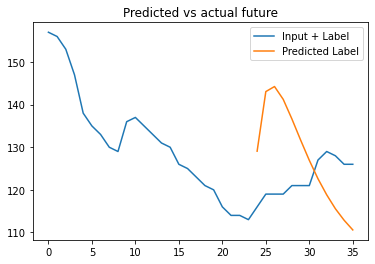

[Training:180] Total Loss: 3.98 Loss: 3.79: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.4060, 0.4390, 0.4358, 0.4242, 0.4089, 0.3946, 0.3831, 0.3756, 0.3719,
        0.3737, 0.3781, 0.3834], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3700, 0.3400, 0.3275, 0.3300, 0.3125, 0.3225, 0.3400, 0.3650, 0.3875,
        0.4325, 0.4475, 0.4525], device='cuda:0')


[Training:181] Total Loss: 3.97 Loss: 3.85: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.6124, 0.6845, 0.7189, 0.7398, 0.7543, 0.7653, 0.7738, 0.7795, 0.7819,
        0.7808, 0.7770, 0.7713], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.9000, 0.8875, 0.8800, 0.8675, 0.8575, 0.8525, 0.8425, 0.8175, 0.7725,
        0.7275, 0.6900, 0.6675], device='cuda:0')


[Training:182] Total Loss: 3.95 Loss: 3.78: 100%|██████████| 93/93 [00:19<00:00,  4.85it/s]


tensor([0.2455, 0.2989, 0.3118, 0.3115, 0.3065, 0.2993, 0.2914, 0.2833, 0.2747,
        0.2664, 0.2589, 0.2522], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3225, 0.3100, 0.3000, 0.2925, 0.2925, 0.2875, 0.2825, 0.2750, 0.2625,
        0.2550, 0.2525, 0.2500], device='cuda:0')


[Training:183] Total Loss: 3.94 Loss: 3.86: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.4923, 0.5587, 0.5926, 0.6137, 0.6277, 0.6372, 0.6425, 0.6442, 0.6426,
        0.6378, 0.6302, 0.6202], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7125, 0.7050, 0.6975, 0.6900, 0.6775, 0.6675, 0.6400, 0.6125, 0.5825,
        0.5500, 0.5175, 0.4925], device='cuda:0')


[Training:184] Total Loss: 3.93 Loss: 4.05: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.4912, 0.5419, 0.5565, 0.5600, 0.5587, 0.5550, 0.5499, 0.5438, 0.5372,
        0.5304, 0.5238, 0.5170], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5800, 0.5700, 0.5600, 0.5375, 0.5200, 0.5075, 0.4950, 0.4825, 0.4725,
        0.4650, 0.4600, 0.4525], device='cuda:0')


[Training:185] Total Loss: 3.92 Loss: 3.84: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3765, 0.4493, 0.4845, 0.5096, 0.5311, 0.5500, 0.5666, 0.5811, 0.5920,
        0.6003, 0.6077, 0.6133], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6325, 0.6600, 0.6800, 0.6900, 0.6975, 0.6950, 0.6850, 0.6775, 0.6450,
        0.6300, 0.6325, 0.6150], device='cuda:0')


[Training:186] Total Loss: 3.91 Loss: 3.64: 100%|██████████| 93/93 [00:19<00:00,  4.85it/s]


tensor([0.4320, 0.4820, 0.4985, 0.5018, 0.4985, 0.4900, 0.4790, 0.4679, 0.4579,
        0.4481, 0.4353, 0.4224], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4975, 0.4875, 0.4700, 0.4575, 0.4425, 0.4125, 0.3975, 0.3925, 0.3975,
        0.3875, 0.3475, 0.3400], device='cuda:0')


[Training:187] Total Loss: 3.90 Loss: 3.86: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.2628, 0.2915, 0.2868, 0.2763, 0.2652, 0.2550, 0.2473, 0.2412, 0.2357,
        0.2309, 0.2270, 0.2244], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.2175, 0.2250, 0.2400, 0.2450, 0.2475, 0.2600, 0.2600, 0.2550,
        0.2500, 0.2500, 0.2550], device='cuda:0')


[Training:188] Total Loss: 3.89 Loss: 3.92: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.2605, 0.2979, 0.2971, 0.2863, 0.2741, 0.2636, 0.2544, 0.2466, 0.2381,
        0.2282, 0.2181, 0.2085], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2675, 0.2600, 0.2450, 0.2350, 0.2400, 0.2500, 0.2500, 0.2500, 0.2300,
        0.2050, 0.1925, 0.1850], device='cuda:0')


[Training:189] Total Loss: 3.88 Loss: 4.32: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.5131, 0.5611, 0.5816, 0.5955, 0.6086, 0.6216, 0.6341, 0.6459, 0.6573,
        0.6678, 0.6776, 0.6862], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6525, 0.6275, 0.6050, 0.6325, 0.6725, 0.6975, 0.7100, 0.7200, 0.7275,
        0.7300, 0.7325, 0.7275], device='cuda:0')


[Training:190] Total Loss: 3.87 Loss: 4.05: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3322, 0.3718, 0.3785, 0.3780, 0.3764, 0.3762, 0.3775, 0.3812, 0.3868,
        0.3940, 0.4019, 0.4100], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3600, 0.3750, 0.3850, 0.3975, 0.4150, 0.4275, 0.4475, 0.4625,
        0.4750, 0.4825, 0.4850], device='cuda:0')


[Training:191] Total Loss: 3.86 Loss: 3.74: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.2683, 0.3232, 0.3364, 0.3343, 0.3259, 0.3147, 0.3033, 0.2923, 0.2825,
        0.2737, 0.2660, 0.2592], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3050, 0.3025, 0.2975, 0.2975, 0.2925, 0.2825, 0.2775, 0.2700, 0.2675,
        0.2625, 0.2600, 0.2575], device='cuda:0')


[Training:192] Total Loss: 3.85 Loss: 3.87: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.3068, 0.3489, 0.3586, 0.3571, 0.3517, 0.3451, 0.3387, 0.3334, 0.3290,
        0.3260, 0.3244, 0.3243], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3200, 0.3250, 0.3300, 0.3325, 0.3375, 0.3375, 0.3400, 0.3425, 0.3425,
        0.3475, 0.3525, 0.3600], device='cuda:0')


[Training:193] Total Loss: 3.84 Loss: 3.89: 100%|██████████| 93/93 [00:18<00:00,  4.99it/s]


tensor([0.2416, 0.2721, 0.2693, 0.2559, 0.2391, 0.2224, 0.2075, 0.1951, 0.1845,
        0.1759, 0.1691, 0.1644], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1675, 0.1650, 0.1700, 0.1700, 0.1675, 0.1675, 0.1700, 0.1750, 0.1725,
        0.1750, 0.1775, 0.1850], device='cuda:0')


[Training:194] Total Loss: 3.84 Loss: 4.15: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]

tensor([0.2922, 0.3317, 0.3352, 0.3281, 0.3168, 0.3034, 0.2877, 0.2713, 0.2556,
        0.2410, 0.2301, 0.2228], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3250, 0.3150, 0.3100, 0.2925, 0.2750, 0.2550, 0.2250, 0.2050, 0.1950,
        0.1875, 0.2050, 0.2225], device='cuda:0')


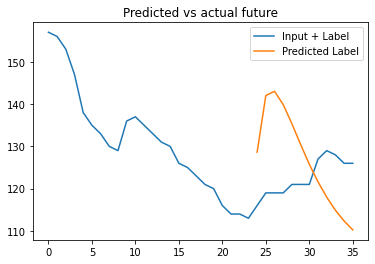

[Training:195] Total Loss: 3.83 Loss: 4.02: 100%|██████████| 93/93 [00:19<00:00,  4.73it/s]


tensor([0.1820, 0.2345, 0.2495, 0.2549, 0.2570, 0.2576, 0.2575, 0.2563, 0.2541,
        0.2509, 0.2463, 0.2413], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3325, 0.3375, 0.3350, 0.3275, 0.3200, 0.3125, 0.3050, 0.2925, 0.2800,
        0.2675, 0.2500, 0.2425], device='cuda:0')


[Training:196] Total Loss: 3.82 Loss: 3.92: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.5403, 0.5898, 0.6051, 0.6101, 0.6107, 0.6100, 0.6086, 0.6074, 0.6074,
        0.6089, 0.6111, 0.6136], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5900, 0.5775, 0.5900, 0.5800, 0.5725, 0.5725, 0.5700, 0.5725, 0.5850,
        0.5975, 0.6025, 0.6050], device='cuda:0')


[Training:197] Total Loss: 3.81 Loss: 3.46: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3514, 0.3786, 0.3745, 0.3635, 0.3508, 0.3392, 0.3297, 0.3220, 0.3154,
        0.3101, 0.3057, 0.3021], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2950, 0.2925, 0.3000, 0.3000, 0.2950, 0.3025, 0.3125, 0.3150, 0.3150,
        0.3150, 0.3150, 0.3150], device='cuda:0')


[Training:198] Total Loss: 3.80 Loss: 3.47: 100%|██████████| 93/93 [00:19<00:00,  4.83it/s]


tensor([0.4135, 0.4563, 0.4623, 0.4580, 0.4497, 0.4403, 0.4316, 0.4244, 0.4180,
        0.4125, 0.4079, 0.4045], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4275, 0.4175, 0.4125, 0.4050, 0.3925, 0.3875, 0.3900, 0.3950, 0.3925,
        0.3925, 0.3925, 0.3975], device='cuda:0')


[Training:199] Total Loss: 3.79 Loss: 3.48: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.2344, 0.2752, 0.2796, 0.2721, 0.2608, 0.2486, 0.2374, 0.2278, 0.2199,
        0.2130, 0.2070, 0.2019], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2050, 0.2100, 0.2125, 0.2150, 0.2175, 0.2175, 0.2225, 0.2250, 0.2275,
        0.2225, 0.2200, 0.2175], device='cuda:0')


[Training:200] Total Loss: 3.78 Loss: 3.59: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.3986, 0.4408, 0.4483, 0.4471, 0.4433, 0.4388, 0.4344, 0.4304, 0.4266,
        0.4241, 0.4240, 0.4229], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4275, 0.4350, 0.4350, 0.4300, 0.4275, 0.4250, 0.4225, 0.4200, 0.4150,
        0.4225, 0.4400, 0.4225], device='cuda:0')


[Training:201] Total Loss: 3.77 Loss: 3.45: 100%|██████████| 93/93 [00:18<00:00,  5.01it/s]


tensor([0.4135, 0.4614, 0.4751, 0.4800, 0.4810, 0.4804, 0.4791, 0.4773, 0.4756,
        0.4743, 0.4729, 0.4717], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4900, 0.4950, 0.5025, 0.5000, 0.4875, 0.4825, 0.4750, 0.4675, 0.4650,
        0.4650, 0.4600, 0.4600], device='cuda:0')


[Training:202] Total Loss: 3.77 Loss: 4.11: 100%|██████████| 93/93 [00:18<00:00,  5.07it/s]


tensor([0.1764, 0.2109, 0.2079, 0.1935, 0.1759, 0.1587, 0.1432, 0.1299, 0.1188,
        0.1097, 0.1024, 0.0965], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000], device='cuda:0')


[Training:203] Total Loss: 3.75 Loss: 3.40: 100%|██████████| 93/93 [00:18<00:00,  4.97it/s]


tensor([0.3751, 0.4234, 0.4384, 0.4411, 0.4376, 0.4321, 0.4266, 0.4215, 0.4175,
        0.4148, 0.4121, 0.4091], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4275, 0.4275, 0.4200, 0.4125, 0.4025, 0.4025, 0.4075, 0.4075, 0.4125,
        0.4175, 0.4100, 0.4025], device='cuda:0')


[Training:204] Total Loss: 3.75 Loss: 3.66: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.2739, 0.3148, 0.3192, 0.3105, 0.2968, 0.2816, 0.2668, 0.2534, 0.2416,
        0.2314, 0.2225, 0.2151], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2625, 0.2575, 0.2500, 0.2425, 0.2350, 0.2275, 0.2225, 0.2200, 0.2175,
        0.2150, 0.2125, 0.2125], device='cuda:0')


[Training:205] Total Loss: 3.74 Loss: 3.52: 100%|██████████| 93/93 [00:18<00:00,  5.00it/s]


tensor([0.4172, 0.4971, 0.5275, 0.5417, 0.5489, 0.5524, 0.5543, 0.5552, 0.5545,
        0.5520, 0.5483, 0.5436], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6000, 0.5950, 0.5775, 0.5725, 0.5600, 0.5500, 0.5450, 0.5400, 0.5225,
        0.5050, 0.4925, 0.4800], device='cuda:0')


[Training:206] Total Loss: 3.73 Loss: 3.70: 100%|██████████| 93/93 [00:18<00:00,  4.98it/s]


tensor([0.1560, 0.2307, 0.2676, 0.2929, 0.3134, 0.3315, 0.3491, 0.3655, 0.3784,
        0.3883, 0.3952, 0.3992], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4175, 0.4350, 0.4575, 0.4775, 0.4925, 0.5000, 0.5150, 0.5150, 0.4900,
        0.4700, 0.4500, 0.4275], device='cuda:0')


[Training:207] Total Loss: 3.72 Loss: 3.82: 100%|██████████| 93/93 [00:17<00:00,  5.27it/s]


tensor([0.3198, 0.3598, 0.3676, 0.3714, 0.3768, 0.3845, 0.3945, 0.4077, 0.4225,
        0.4380, 0.4537, 0.4695], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3500, 0.3650, 0.3925, 0.4250, 0.4575, 0.4825, 0.5050, 0.5375, 0.5550,
        0.5675, 0.5750, 0.5875], device='cuda:0')


[Training:208] Total Loss: 3.72 Loss: 3.82: 100%|██████████| 93/93 [00:19<00:00,  4.88it/s]


tensor([0.4483, 0.5121, 0.5428, 0.5596, 0.5698, 0.5774, 0.5842, 0.5905, 0.5965,
        0.6026, 0.6073, 0.6105], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6250, 0.6225, 0.6150, 0.6050, 0.6000, 0.6075, 0.6150, 0.6175, 0.6200,
        0.6250, 0.6100, 0.5975], device='cuda:0')


[Training:209] Total Loss: 3.71 Loss: 3.50: 100%|██████████| 93/93 [00:18<00:00,  5.06it/s]

tensor([0.3823, 0.4609, 0.4891, 0.5023, 0.5109, 0.5182, 0.5253, 0.5327, 0.5403,
        0.5480, 0.5544, 0.5595], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5250, 0.5325, 0.5400, 0.5475, 0.5550, 0.5625, 0.5700, 0.5775, 0.5825,
        0.5875, 0.5750, 0.5675], device='cuda:0')


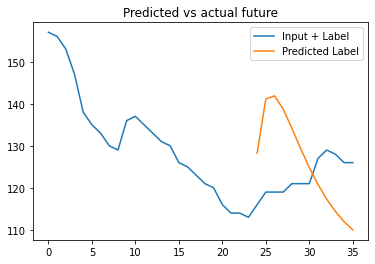

[Training:210] Total Loss: 3.70 Loss: 3.92: 100%|██████████| 93/93 [00:17<00:00,  5.21it/s]


tensor([0.3986, 0.4454, 0.4608, 0.4645, 0.4634, 0.4593, 0.4526, 0.4418, 0.4294,
        0.4177, 0.4084, 0.4009], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4800, 0.4675, 0.4525, 0.4425, 0.4400, 0.4300, 0.4100, 0.3700, 0.3525,
        0.3500, 0.3625, 0.3675], device='cuda:0')


[Training:211] Total Loss: 3.69 Loss: 3.80: 100%|██████████| 93/93 [00:17<00:00,  5.25it/s]


tensor([0.3120, 0.3603, 0.3752, 0.3782, 0.3761, 0.3721, 0.3671, 0.3613, 0.3564,
        0.3533, 0.3518, 0.3499], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3725, 0.3775, 0.3800, 0.3800, 0.3775, 0.3750, 0.3675, 0.3550, 0.3575,
        0.3650, 0.3725, 0.3625], device='cuda:0')


[Training:212] Total Loss: 3.69 Loss: 3.68: 100%|██████████| 93/93 [00:18<00:00,  5.13it/s]


tensor([0.1919, 0.2229, 0.2197, 0.2083, 0.1961, 0.1853, 0.1765, 0.1696, 0.1644,
        0.1609, 0.1586, 0.1583], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1675, 0.1700, 0.1675, 0.1650, 0.1700, 0.1750, 0.1800, 0.1825, 0.1850,
        0.1900, 0.1925, 0.2050], device='cuda:0')


[Training:213] Total Loss: 3.68 Loss: 3.64: 100%|██████████| 93/93 [00:18<00:00,  5.13it/s]


tensor([0.4770, 0.5201, 0.5371, 0.5463, 0.5509, 0.5545, 0.5588, 0.5642, 0.5705,
        0.5772, 0.5841, 0.5906], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5250, 0.5225, 0.5875, 0.5775, 0.5625, 0.5675, 0.5800, 0.5925, 0.6025,
        0.6100, 0.6125, 0.6125], device='cuda:0')


[Training:214] Total Loss: 3.67 Loss: 3.87: 100%|██████████| 93/93 [00:19<00:00,  4.75it/s]


tensor([0.3027, 0.3398, 0.3433, 0.3363, 0.3266, 0.3167, 0.3071, 0.2998, 0.2956,
        0.2940, 0.2932, 0.2934], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2925, 0.2800, 0.2750, 0.2800, 0.2900, 0.2950, 0.2925, 0.3025, 0.3200,
        0.3325, 0.3300, 0.3350], device='cuda:0')


[Training:215] Total Loss: 3.66 Loss: 3.61: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.2784, 0.3044, 0.3002, 0.2916, 0.2840, 0.2789, 0.2764, 0.2770, 0.2798,
        0.2848, 0.2917, 0.3005], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2300, 0.2350, 0.2475, 0.2650, 0.2825, 0.3025, 0.3175, 0.3375, 0.3525,
        0.3675, 0.3825, 0.4025], device='cuda:0')


[Training:216] Total Loss: 3.66 Loss: 3.42: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.1988, 0.2260, 0.2219, 0.2128, 0.2038, 0.1969, 0.1926, 0.1902, 0.1893,
        0.1889, 0.1887, 0.1884], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1575, 0.1625, 0.1750, 0.1925, 0.2025, 0.2150, 0.2275, 0.2350, 0.2400,
        0.2375, 0.2350, 0.2300], device='cuda:0')


[Training:217] Total Loss: 3.65 Loss: 3.87: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.4669, 0.5144, 0.5253, 0.5231, 0.5146, 0.5046, 0.4946, 0.4845, 0.4743,
        0.4637, 0.4534, 0.4436], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5100, 0.5075, 0.4900, 0.4575, 0.4300, 0.4250, 0.4225, 0.4125, 0.4025,
        0.3900, 0.3825, 0.3775], device='cuda:0')


[Training:218] Total Loss: 3.64 Loss: 3.81: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.3502, 0.3823, 0.3830, 0.3788, 0.3757, 0.3772, 0.3842, 0.3957, 0.4101,
        0.4259, 0.4416, 0.4570], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3350, 0.3400, 0.3475, 0.3650, 0.3900, 0.4325, 0.4800, 0.5200, 0.5475,
        0.5625, 0.5675, 0.5725], device='cuda:0')


[Training:219] Total Loss: 3.64 Loss: 3.51: 100%|██████████| 93/93 [00:18<00:00,  4.92it/s]


tensor([0.3776, 0.4245, 0.4397, 0.4433, 0.4412, 0.4368, 0.4322, 0.4275, 0.4221,
        0.4166, 0.4112, 0.4060], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4525, 0.4425, 0.4325, 0.4250, 0.4150, 0.4125, 0.4150, 0.4125, 0.4000,
        0.3925, 0.3875, 0.3825], device='cuda:0')


[Training:220] Total Loss: 3.63 Loss: 3.39: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3991, 0.4427, 0.4523, 0.4541, 0.4545, 0.4549, 0.4543, 0.4537, 0.4536,
        0.4522, 0.4491, 0.4454], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4825, 0.4775, 0.4650, 0.4625, 0.4700, 0.4725, 0.4600, 0.4600, 0.4600,
        0.4425, 0.4250, 0.4175], device='cuda:0')


[Training:221] Total Loss: 3.62 Loss: 3.29: 100%|██████████| 93/93 [00:19<00:00,  4.81it/s]


tensor([0.2499, 0.2973, 0.3069, 0.3032, 0.2939, 0.2827, 0.2716, 0.2613, 0.2518,
        0.2428, 0.2343, 0.2266], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2725, 0.2750, 0.2750, 0.2725, 0.2650, 0.2575, 0.2525, 0.2475, 0.2400,
        0.2300, 0.2225, 0.2175], device='cuda:0')


[Training:222] Total Loss: 3.62 Loss: 3.64: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.2251, 0.2609, 0.2643, 0.2572, 0.2460, 0.2334, 0.2206, 0.2082, 0.1968,
        0.1856, 0.1749, 0.1646], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2525, 0.2625, 0.2700, 0.2425, 0.2200, 0.2025, 0.1875, 0.1750, 0.1675,
        0.1550, 0.1450, 0.1350], device='cuda:0')


[Training:223] Total Loss: 3.61 Loss: 3.56: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.3601, 0.4213, 0.4458, 0.4573, 0.4633, 0.4710, 0.4826, 0.4980, 0.5128,
        0.5263, 0.5402, 0.5548], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5250, 0.4925, 0.4875, 0.4900, 0.4925, 0.5375, 0.5850, 0.6275, 0.6225,
        0.6175, 0.6325, 0.6475], device='cuda:0')


[Training:224] Total Loss: 3.60 Loss: 3.25: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.3385, 0.3750, 0.3775, 0.3718, 0.3642, 0.3564, 0.3488, 0.3417, 0.3353,
        0.3297, 0.3247, 0.3206], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3425, 0.3375, 0.3375, 0.3375, 0.3400, 0.3400, 0.3350, 0.3300, 0.3275,
        0.3250, 0.3225, 0.3225], device='cuda:0')


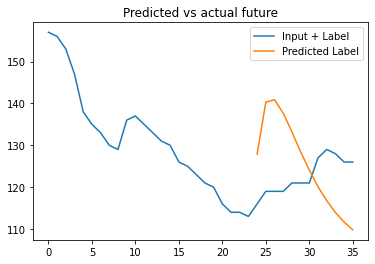

[Training:225] Total Loss: 3.60 Loss: 3.74: 100%|██████████| 93/93 [00:18<00:00,  4.95it/s]


tensor([0.2995, 0.3173, 0.3036, 0.2849, 0.2677, 0.2538, 0.2426, 0.2348, 0.2291,
        0.2249, 0.2231, 0.2221], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2025, 0.1950, 0.1875, 0.1900, 0.2025, 0.2175, 0.2250, 0.2400, 0.2450,
        0.2475, 0.2600, 0.2600], device='cuda:0')


[Training:226] Total Loss: 3.59 Loss: 3.70: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3724, 0.4129, 0.4186, 0.4174, 0.4143, 0.4109, 0.4074, 0.4046, 0.4033,
        0.4020, 0.3997, 0.3964], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4100, 0.3950, 0.3975, 0.4100, 0.4125, 0.4125, 0.4075, 0.4075, 0.4150,
        0.4100, 0.3950, 0.3825], device='cuda:0')


[Training:227] Total Loss: 3.59 Loss: 3.81: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3543, 0.3924, 0.3978, 0.3915, 0.3802, 0.3672, 0.3541, 0.3415, 0.3298,
        0.3191, 0.3096, 0.3010], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3475, 0.3375, 0.3300, 0.3225, 0.3150, 0.3075, 0.3025, 0.2950, 0.2900,
        0.2850, 0.2825, 0.2775], device='cuda:0')


[Training:228] Total Loss: 3.58 Loss: 3.77: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.2912, 0.3275, 0.3320, 0.3262, 0.3168, 0.3067, 0.2970, 0.2884, 0.2812,
        0.2755, 0.2710, 0.2677], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2700, 0.2700, 0.2750, 0.2775, 0.2775, 0.2800, 0.2800, 0.2800, 0.2825,
        0.2850, 0.2850, 0.2875], device='cuda:0')


[Training:229] Total Loss: 3.57 Loss: 3.42: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.3642, 0.3897, 0.3816, 0.3642, 0.3425, 0.3185, 0.2939, 0.2703, 0.2487,
        0.2295, 0.2130, 0.1985], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3050, 0.2825, 0.2725, 0.2525, 0.2250, 0.1950, 0.1725, 0.1575, 0.1500,
        0.1475, 0.1475, 0.1450], device='cuda:0')


[Training:230] Total Loss: 3.57 Loss: 3.81: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3502, 0.3789, 0.3748, 0.3634, 0.3508, 0.3394, 0.3296, 0.3210, 0.3137,
        0.3074, 0.3016, 0.2954], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3150, 0.3075, 0.3025, 0.3000, 0.3000, 0.3050, 0.3075, 0.3050, 0.3050,
        0.3025, 0.2975, 0.2850], device='cuda:0')


[Training:231] Total Loss: 3.56 Loss: 3.69: 100%|██████████| 93/93 [00:19<00:00,  4.76it/s]


tensor([0.3759, 0.4552, 0.4902, 0.5072, 0.5162, 0.5209, 0.5230, 0.5230, 0.5214,
        0.5184, 0.5142, 0.5088], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6000, 0.5825, 0.5700, 0.5575, 0.5475, 0.5350, 0.5200, 0.5050, 0.4900,
        0.4750, 0.4625, 0.4475], device='cuda:0')


[Training:232] Total Loss: 3.56 Loss: 3.36: 100%|██████████| 93/93 [00:19<00:00,  4.78it/s]


tensor([0.2425, 0.2853, 0.2974, 0.3028, 0.3091, 0.3157, 0.3206, 0.3260, 0.3315,
        0.3367, 0.3410, 0.3450], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2400, 0.2525, 0.2975, 0.3475, 0.3975, 0.4150, 0.4050, 0.4100, 0.4100,
        0.4050, 0.3975, 0.3950], device='cuda:0')


[Training:233] Total Loss: 3.55 Loss: 3.50: 100%|██████████| 93/93 [00:18<00:00,  4.93it/s]


tensor([0.3285, 0.3621, 0.3646, 0.3565, 0.3436, 0.3290, 0.3144, 0.2991, 0.2840,
        0.2694, 0.2556, 0.2424], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3025, 0.2950, 0.2925, 0.2850, 0.2725, 0.2650, 0.2575, 0.2400, 0.2275,
        0.2150, 0.2050, 0.1950], device='cuda:0')


[Training:234] Total Loss: 3.55 Loss: 3.37: 100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


tensor([0.3046, 0.3402, 0.3416, 0.3346, 0.3258, 0.3177, 0.3106, 0.3048, 0.3003,
        0.2968, 0.2939, 0.2917], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3100, 0.3100, 0.3075, 0.3050, 0.3050, 0.3100, 0.3100, 0.3100, 0.3125,
        0.3125, 0.3100, 0.3100], device='cuda:0')


[Training:235] Total Loss: 3.54 Loss: 3.57: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


tensor([0.3461, 0.3764, 0.3832, 0.3843, 0.3855, 0.3893, 0.3958, 0.4049, 0.4158,
        0.4282, 0.4420, 0.4571], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3225, 0.3425, 0.3650, 0.3850, 0.4125, 0.4475, 0.4750, 0.5000, 0.5175,
        0.5350, 0.5525, 0.5725], device='cuda:0')


[Training:236] Total Loss: 3.54 Loss: 3.83: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.2892, 0.3084, 0.3000, 0.2885, 0.2791, 0.2739, 0.2739, 0.2793, 0.2893,
        0.3011, 0.3114, 0.3211], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1775, 0.2025, 0.2250, 0.2475, 0.2700, 0.3000, 0.3375, 0.3775, 0.4150,
        0.4300, 0.4175, 0.4175], device='cuda:0')


[Training:237] Total Loss: 3.53 Loss: 3.27: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.5075, 0.5589, 0.5762, 0.5833, 0.5861, 0.5865, 0.5855, 0.5844, 0.5834,
        0.5837, 0.5858, 0.5899], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6400, 0.6275, 0.6100, 0.5900, 0.5750, 0.5625, 0.5525, 0.5500, 0.5500,
        0.5600, 0.5775, 0.5950], device='cuda:0')


[Training:238] Total Loss: 3.52 Loss: 3.56: 100%|██████████| 93/93 [00:19<00:00,  4.83it/s]


tensor([0.4734, 0.5243, 0.5409, 0.5472, 0.5497, 0.5502, 0.5478, 0.5441, 0.5403,
        0.5367, 0.5345, 0.5336], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5650, 0.5650, 0.5700, 0.5525, 0.5475, 0.5375, 0.5100, 0.4975, 0.4950,
        0.4925, 0.5025, 0.5100], device='cuda:0')


[Training:239] Total Loss: 3.52 Loss: 3.80: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.2503, 0.2689, 0.2556, 0.2358, 0.2160, 0.1984, 0.1844, 0.1736, 0.1656,
        0.1600, 0.1560, 0.1529], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1650, 0.1550, 0.1475, 0.1400, 0.1375, 0.1400, 0.1500, 0.1575, 0.1650,
        0.1725, 0.1750, 0.1750], device='cuda:0')


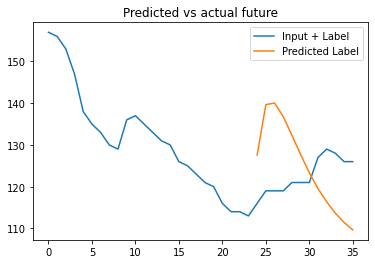

[Training:240] Total Loss: 3.51 Loss: 3.60: 100%|██████████| 93/93 [00:19<00:00,  4.83it/s]


tensor([0.4834, 0.5234, 0.5309, 0.5301, 0.5265, 0.5218, 0.5157, 0.5091, 0.5041,
        0.4988, 0.4922, 0.4846], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5375, 0.5150, 0.5025, 0.4925, 0.4850, 0.4800, 0.4625, 0.4550, 0.4650,
        0.4525, 0.4350, 0.4200], device='cuda:0')


[Training:241] Total Loss: 3.51 Loss: 3.34: 100%|██████████| 93/93 [00:18<00:00,  4.90it/s]


tensor([0.3984, 0.4845, 0.5194, 0.5381, 0.5507, 0.5612, 0.5707, 0.5781, 0.5837,
        0.5887, 0.5933, 0.5984], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6150, 0.6250, 0.6175, 0.6125, 0.6075, 0.6125, 0.6150, 0.6000, 0.5900,
        0.5900, 0.5900, 0.6000], device='cuda:0')


[Training:242] Total Loss: 3.50 Loss: 3.21: 100%|██████████| 93/93 [00:19<00:00,  4.78it/s]


tensor([0.3533, 0.3847, 0.3822, 0.3718, 0.3596, 0.3478, 0.3373, 0.3286, 0.3218,
        0.3165, 0.3120, 0.3086], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3275, 0.3225, 0.3150, 0.3100, 0.3075, 0.3075, 0.3075, 0.3100, 0.3150,
        0.3175, 0.3150, 0.3175], device='cuda:0')


[Training:243] Total Loss: 3.50 Loss: 3.50: 100%|██████████| 93/93 [00:18<00:00,  4.91it/s]


tensor([0.3969, 0.4354, 0.4417, 0.4398, 0.4351, 0.4298, 0.4246, 0.4198, 0.4155,
        0.4117, 0.4085, 0.4057], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4250, 0.4200, 0.4200, 0.4175, 0.4125, 0.4100, 0.4075, 0.4050, 0.4025,
        0.4000, 0.4000, 0.3975], device='cuda:0')


[Training:244] Total Loss: 3.49 Loss: 3.22: 100%|██████████| 93/93 [00:19<00:00,  4.89it/s]


tensor([0.3504, 0.3820, 0.3843, 0.3764, 0.3651, 0.3524, 0.3398, 0.3276, 0.3154,
        0.3038, 0.2930, 0.2816], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2925, 0.3125, 0.3100, 0.3025, 0.3025, 0.2950, 0.2925, 0.2850, 0.2725,
        0.2650, 0.2575, 0.2400], device='cuda:0')


[Training:245] Total Loss: 3.49 Loss: 3.40: 100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


tensor([0.2276, 0.2709, 0.2852, 0.2963, 0.3085, 0.3226, 0.3388, 0.3569, 0.3760,
        0.3958, 0.4167, 0.4406], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2900, 0.3200, 0.3625, 0.4125, 0.4475, 0.4750, 0.5000, 0.5225, 0.5400,
        0.5550, 0.5775, 0.6225], device='cuda:0')


[Training:246] Total Loss: 3.49 Loss: 3.90: 100%|██████████| 93/93 [00:18<00:00,  5.09it/s]


tensor([0.2945, 0.3440, 0.3558, 0.3537, 0.3462, 0.3369, 0.3276, 0.3192, 0.3113,
        0.3041, 0.2976, 0.2915], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3300, 0.3275, 0.3250, 0.3225, 0.3175, 0.3150, 0.3100, 0.3075, 0.3000,
        0.2950, 0.2900, 0.2850], device='cuda:0')


[Training:247] Total Loss: 3.48 Loss: 3.47: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


tensor([0.3286, 0.3794, 0.3965, 0.4018, 0.4031, 0.4036, 0.4030, 0.4014, 0.4006,
        0.4008, 0.4008, 0.4025], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3925, 0.3925, 0.4025, 0.4125, 0.4225, 0.4325, 0.4250, 0.4150, 0.4175,
        0.4225, 0.4150, 0.4300], device='cuda:0')


[Training:248] Total Loss: 3.48 Loss: 3.63: 100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


tensor([0.2906, 0.3138, 0.3049, 0.2894, 0.2729, 0.2571, 0.2432, 0.2313, 0.2206,
        0.2113, 0.2040, 0.1981], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2275, 0.2250, 0.2175, 0.2150, 0.2100, 0.2050, 0.2050, 0.2050, 0.1975,
        0.1950, 0.2000, 0.2000], device='cuda:0')


[Training:249] Total Loss: 3.47 Loss: 3.38: 100%|██████████| 93/93 [00:19<00:00,  4.87it/s]

tensor([0.2525, 0.2762, 0.2736, 0.2687, 0.2650, 0.2625, 0.2603, 0.2591, 0.2601,
        0.2643, 0.2710, 0.2791], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1800, 0.1975, 0.2400, 0.2750, 0.2950, 0.3025, 0.3000, 0.3025, 0.3150,
        0.3400, 0.3600, 0.3725], device='cuda:0')


In [26]:
train_losses = []
val_losses = []

torch.autograd.set_detect_anomaly(False)
loss_function = nn.MSELoss()
best_val_loss = torch.inf
stopping_counter = 0
for epoch in range(epochs):
    total_loss = 0
    with torch.no_grad():
        if epoch % 15 == 0:
            x, y, inp = val_data.get_first_example()
            x = torch.tensor(x).unsqueeze(0)
            x = prepare_data(x).to(device)
            model = model.eval()
            y = torch.tensor(y).unsqueeze(0).unsqueeze(2).to(device)
            y_pred = model(x, x[-1].unsqueeze(0)[:, :, 2].unsqueeze(2), teacher_force=False)[:, 0, 0].cpu().numpy()
            model = model.train()
            fig = plot_example(y.cpu().squeeze(), y_pred, inp, scale_factor=train_data.scale_max["cbg"])
            plt.show()
        with tqdm(val_loader) as t:
            for x, y, mask in t:
                x = prepare_data(x).to(device)
                y = y.to(device).unsqueeze(2).permute(1, 0, 2)
                y_pred = model(x, x[-1].unsqueeze(0)[:, :, 2].unsqueeze(2), teacher_force=False)
                loss = loss_function(y_pred, y) * 1000
                val_loss = loss
                total_loss += loss.item()
                t.set_description(f"[Validation:{epoch - 1}] Total Loss: {total_loss / len(val_loader):.2f} Loss: {loss.item():.2f}")
    val_losses.append(total_loss / len(val_loader))
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        torch.save(model.state_dict(), f"checkpoints/lstm_best_{output_dim}.chkpt")
        stopping_counter = 0
    else: 
        stopping_counter += 1
        if stopping_counter >= early_stopping_counter:
            break
    total_loss = 0
    with tqdm(train_loader) as t:
        for x, y, mask in t:
            x = prepare_data(x).to(device)
            y = y.to(device).unsqueeze(2).permute(1, 0, 2)
            y_pred = model(x, y)[:, :, 0]
            y = y.permute(1, 0, 2)[:, :, 0]

            loss = loss_function(y_pred, y) * 1000
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            t.set_description(f"[Training:{epoch}] Total Loss: {total_loss / len(train_loader):.2f} Loss: {loss.item():.2f}")
        print(y_pred[0], y[0])
    train_losses.append(total_loss / len(train_loader))
    
    scheduler.step(val_loss)
    scheduler2.step()


# Plot Train/Val loss curves

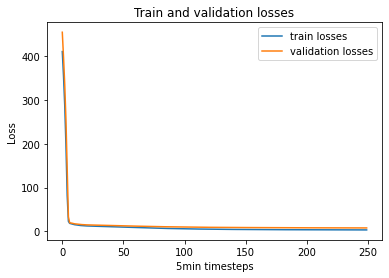

In [27]:
plt.plot(train_losses, label="train losses")
plt.plot(val_losses, label="validation losses")

plt.title(f"Train and validation losses")
plt.ylabel("Loss")
plt.xlabel("5min timesteps")
plt.legend()
plt.show()

# Evaluate on test set
* Calculate the rMSE and MAE values for 30min/60min prediction horizon

In [45]:
test_data = OhioData(mode="test", h=output_dim)
test_loader = DataLoader(test_data, batch_size=1, num_workers=0)

mse_loss = nn.MSELoss()
model = LSTMPredictor(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, prediction_horizon=output_dim, bidirectional=False).to(device)
model.load_state_dict(torch.load(f"checkpoints/lstm_best_{output_dim}.chkpt"))
model = model.eval().to(device)

In [30]:
total_loss = 0

with torch.no_grad():
    with tqdm(test_loader) as t:
        for x, y, mask in t:
            x = prepare_data(x).to(device)
            y = y.to(device).unsqueeze(2).permute(1, 0, 2)
            y_pred = model(x, x[-1].unsqueeze(0)[:, :, 2].unsqueeze(2), teacher_force=False)[:, :]
            # scale back to original range, because otherwise the results cannot bne compared to others
            y = y * train_data.scale_max["cbg"]
            y_pred = y_pred * train_data.scale_max["cbg"]
            loss = mse_loss(y_pred, y)
            total_loss += loss.item()
            t.set_description(f"Test Loss: {np.sqrt(total_loss / len(test_loader)):.2f}, Running Loss: {np.sqrt(loss.item()):.2f}")

print(f"Final rMSE: {np.sqrt(total_loss / len(test_loader))}")

Test Loss: 29.01, Running Loss: 31.75: 100%|██████████| 28426/28426 [01:22<00:00, 345.43it/s] 

Final rMSE: 29.009450666605456


# Evaluate results per patient

In [31]:
patient_ids = [559, 563, 570, 575, 588, 591, 540, 544, 552, 567, 584, 596]

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [46]:
maes = []
mses = []
with torch.no_grad():
    for id in patient_ids:
        total_mae = 0
        total_mse = 0
        test_data = OhioData(mode="test", patient_id=id, h=output_dim)
        test_loader = DataLoader(test_data, batch_size=1, num_workers=0)
        with tqdm(test_loader) as t:
            for x, y, mask in t:
                x = prepare_data(x).to(device)
                y = y.to(device).unsqueeze(2).permute(1, 0, 2)
                y_pred = model(x, x[-1].unsqueeze(0)[:, :, 2].unsqueeze(2), teacher_force=False)[:, :]
                # y = y.permute(1, 0, 2)[:, :, 0]
                y = y * train_data.scale_max["cbg"]
                y_pred = y_pred * train_data.scale_max["cbg"]
                mse = mse_loss(y_pred, y)
                mae = mae_loss(y_pred, y)
                total_mae += mae.item()
                total_mse += mse.item()
                t.set_description(f"Patient: {id}, rMSE: {np.sqrt(total_mse / len(test_loader)):.2f}, MAE: {total_mae / len(test_loader):.2f}")
        print(f"Results - Patient: {id}, rMSE: {np.sqrt(total_mse / len(test_loader)):.2f}, MAE: {total_mae / len(test_loader):.2f}")
        maes.append(total_mae / len(test_loader))
        mses.append(total_mse / len(test_loader))
print(f"Mean results - MAE: {sum(maes) / len(maes)}, rMSE: {np.sqrt(sum(mses) / len(mses))}")

Patient: 559, rMSE: 14.88, MAE: 9.81: 100%|██████████| 2142/2142 [00:06<00:00, 327.72it/s]


Results - Patient: 559, rMSE: 14.88, MAE: 9.81


Patient: 563, rMSE: 14.71, MAE: 9.96: 100%|██████████| 2446/2446 [00:07<00:00, 347.29it/s]


Results - Patient: 563, rMSE: 14.71, MAE: 9.96


Patient: 570, rMSE: 12.18, MAE: 8.31: 100%|██████████| 2435/2435 [00:06<00:00, 348.73it/s]


Results - Patient: 570, rMSE: 12.18, MAE: 8.31


Patient: 575, rMSE: 16.94, MAE: 10.51: 100%|██████████| 2249/2249 [00:06<00:00, 348.62it/s]


Results - Patient: 575, rMSE: 16.94, MAE: 10.51


Patient: 588, rMSE: 14.60, MAE: 9.92: 100%|██████████| 2698/2698 [00:07<00:00, 337.83it/s]


Results - Patient: 588, rMSE: 14.60, MAE: 9.92


Patient: 591, rMSE: 16.37, MAE: 11.10: 100%|██████████| 2605/2605 [00:07<00:00, 352.09it/s]


Results - Patient: 591, rMSE: 16.37, MAE: 11.10


Patient: 540, rMSE: 18.36, MAE: 12.42: 100%|██████████| 2617/2617 [00:07<00:00, 355.01it/s]


Results - Patient: 540, rMSE: 18.36, MAE: 12.42


Patient: 544, rMSE: 13.97, MAE: 9.60: 100%|██████████| 2499/2499 [00:07<00:00, 352.44it/s]


Results - Patient: 544, rMSE: 13.97, MAE: 9.60


Patient: 552, rMSE: 13.62, MAE: 9.11: 100%|██████████| 2023/2023 [00:05<00:00, 358.37it/s]


Results - Patient: 552, rMSE: 13.62, MAE: 9.11


Patient: 567, rMSE: 17.86, MAE: 11.65: 100%|██████████| 2017/2017 [00:05<00:00, 355.50it/s]


Results - Patient: 567, rMSE: 17.86, MAE: 11.65


Patient: 584, rMSE: 16.62, MAE: 11.31: 100%|██████████| 2169/2169 [00:06<00:00, 359.08it/s]


Results - Patient: 584, rMSE: 16.62, MAE: 11.31


Patient: 596, rMSE: 13.98, MAE: 9.33: 100%|██████████| 2526/2526 [00:07<00:00, 356.38it/s]

Results - Patient: 596, rMSE: 13.98, MAE: 9.33
Mean results - MAE: 10.253595402125447, rMSE: 15.443822115313193


# Vizualize the **predictions**

## NOTE(!!!)

* all time steps where missing_cbg == True, the data is removed

In [ ]:
def plot_point(y, y_pred, model_name):
    fig, ax = plt.subplots(1)
    line = ax.plot(y, label="Groud Truth")
    line = ax.plot(y_pred, label="Prediction")
    _ = ax.set_title(f"Prediction vs Ground truth with model {model_name}")
    _ = ax.set_ylabel("mg/dL")
    _ = ax.set_xlabel("5min timesteps")

    legend = ax.legend()
    return fig

100%|██████████| 2142/2142 [00:04<00:00, 431.78it/s]


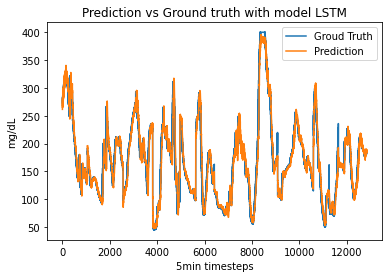

100%|██████████| 2446/2446 [00:05<00:00, 463.45it/s]


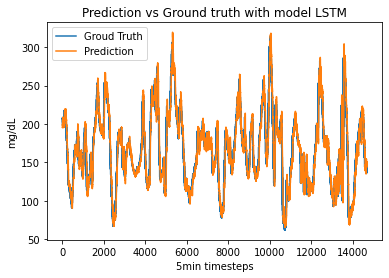

100%|██████████| 2435/2435 [00:05<00:00, 485.67it/s]


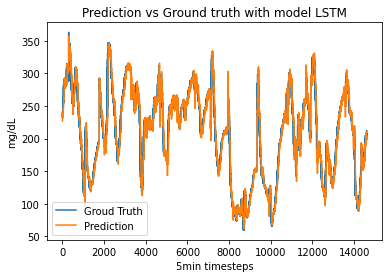

100%|██████████| 2249/2249 [00:05<00:00, 429.55it/s]


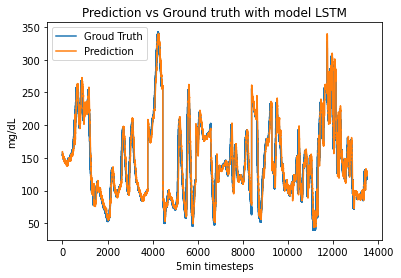

100%|██████████| 2698/2698 [00:06<00:00, 424.96it/s]


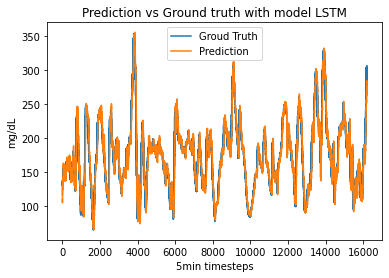

100%|██████████| 2605/2605 [00:06<00:00, 388.54it/s]


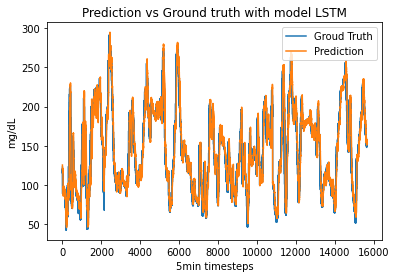

100%|██████████| 2617/2617 [00:05<00:00, 468.49it/s]


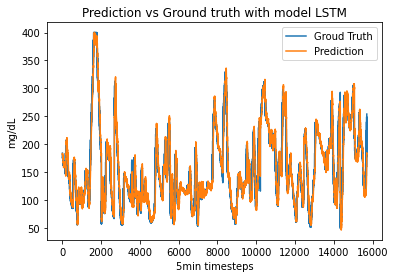

100%|██████████| 2499/2499 [00:05<00:00, 427.18it/s]


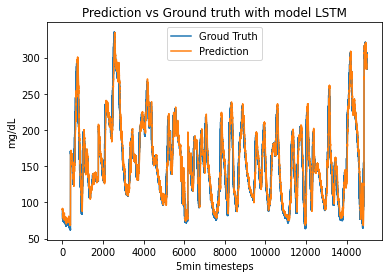

100%|██████████| 2023/2023 [00:05<00:00, 375.77it/s]


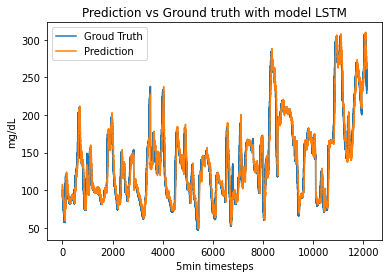

100%|██████████| 2017/2017 [00:05<00:00, 354.55it/s]


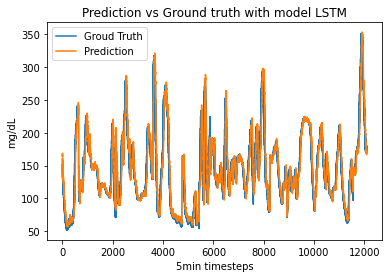

100%|██████████| 2169/2169 [00:05<00:00, 362.94it/s]


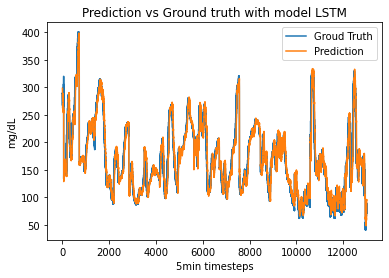

100%|██████████| 2526/2526 [00:06<00:00, 373.44it/s]


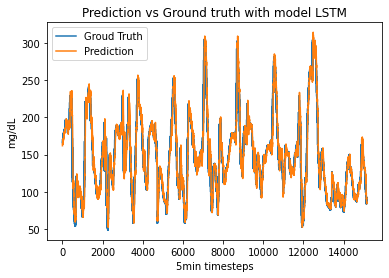

In [ ]:
# plot_point([1,2,3,4], [2,3,4,5], "N-BEATS")

for id in patient_ids:
    test_data = OhioData(mode="test", patient_id=id, h = output_dim35.17)
    test_loader = DataLoader(test_data, batch_size=1, num_workers=0)
    y_values = []
    y_pred_values = []
    with torch.no_grad():
        with tqdm(test_loader) as t:
            for x, y, mask in t:
                x = prepare_data(x).to(device)
                y = y.to(device).unsqueeze(2).permute(1, 0, 2).squeeze()
                y_pred = model(x, x[-1].unsqueeze(0)[:, :, 2].unsqueeze(2), teacher_force=False).squeeze()
                y = y * train_data.scale_max["cbg"]
                y_pred = y_pred * train_data.scale_max["cbg"]
                y_values.extend(y.tolist())
                y_pred_values.extend(y_pred.tolist())
                
    fig = plot_point(y_values, y_pred_values, "LSTM")
    plt.show(fig)